# Load up required libraries and dataset

In [1]:
#Standard Math / Data Package
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize

#Plotting Package
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
%matplotlib inline

#Data Splitting, Scaling and Cross Validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from keras_tuner.tuners import RandomSearch

#ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Scoring and metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score
from sklearn.metrics import roc_curve, auc

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('future.no_silent_downcasting', True)

In [2]:
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'Times New Roman'

In [3]:
# Helper function to calculate misclassification
def calc_misclass(actual, predicted):
    return np.mean(actual != predicted)

# Helper function to calculate specificity
def calc_specificity(actual, predicted):
    tn, fp, _, _ = confusion_matrix(actual, predicted).ravel()
    specificity = tn / (tn+fp)
    return np.round(specificity,5)

# Helper function to calculate sensitivity
def calc_sensitivity(actual, predicted):
    _, _, fn, tp = confusion_matrix(actual, predicted).ravel()
    sensitivity = tp / (tp+fn)
    return np.round(sensitivity,5)

In [4]:
data_dir = 'data/'  
data_file = data_dir + 'diabetes.csv'

data = pd.read_csv(data_file)

print(data.shape)
data.head()

(768, 9)


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [5]:
summary = data.iloc[:,:-1].describe().loc[['min','25%','50%','mean','75%','max']]
summary = summary.reset_index(drop=True)
summary[''] = ['Min','1st Qu.','Median','Mean','3rd Qu.','Max']
summary.set_index('', inplace=True);summary.round(2)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
                                                                              
Min             0.00     0.00           0.00           0.00     0.00   0.00   
1st Qu.         1.00    99.00          62.00           0.00     0.00  27.30   
Median          3.00   117.00          72.00          23.00    30.50  32.00   
Mean            3.85   120.89          69.11          20.54    79.80  31.99   
3rd Qu.         6.00   140.25          80.00          32.00   127.25  36.60   
Max            17.00   199.00         122.00          99.00   846.00  67.10   

         DiabetesPedigreeFunction    Age  
                                          
Min                          0.08  21.00  
1st Qu.                      0.24  24.00  
Median                       0.37  29.00  
Mean                         0.47  33.24  
3rd Qu.                      0.63  41.00  
Max                          2.42  81.00

&nbsp;

# Data Cleaning & Preparation

In [6]:
#Zero values are not within the normal range and are therefore inaccurate
data['Glucose'] = data['Glucose'].replace({0: np.nan})
data['BloodPressure'] = data['BloodPressure'].replace({0: np.nan})
data['SkinThickness'] = data['SkinThickness'].replace({0: np.nan})
data['Insulin'] = data['Insulin'].replace({0: np.nan})
data['BMI'] = data['BMI'].replace({0: np.nan})

#Remove records that have 4 NaN values (7 records total)
data = data.loc[~(data['BloodPressure'].isnull()&
                  data['SkinThickness'].isnull()&
                  data['Insulin'].isnull()&
                  data['BMI'].isnull())]

#Remove records that have 3 NaN values (26 records total)
data = data.loc[~(data['BloodPressure'].isnull()&
                  data['SkinThickness'].isnull()&
                  data['Insulin'].isnull())]

#Remove records that have 3 NaN values (2 records total)
data = data.loc[~(data['BMI'].isnull()&
                  data['SkinThickness'].isnull()&
                  data['Insulin'].isnull())]

#Classification algorithms are designed to assume that the dataset is balanced
#we applied a data undersampling technique
#The goal here is to remove records that simultaneously have NaN values or are outliers
data = data.loc[~((data['Outcome']==0)&
                  (data['SkinThickness'].isnull()))]

data = data.loc[~((data['Outcome']==0)&
                  (data['Glucose'].isnull()))]

data = data.loc[~((data['Outcome']==0)&
                  (data['BloodPressure'].isnull()))]

data = data.loc[~((data['Outcome']==0)&
                  (data['BMI'].isnull()))]

data = data.loc[~((data['Outcome']==0)&
                  (data['Insulin'].isnull()))]

data = data.loc[~((data['Outcome']==0)&
                  (data['Insulin'] > np.quantile(data.loc[data['Outcome']==0, 'Insulin'], 0.95))&
                  (data['Glucose'] > np.quantile(data.loc[data['Outcome']==0, 'Glucose'], 0.95)))]

data = data.loc[~((data['Outcome']==0)&
                  (data['Insulin'] > np.quantile(data.loc[data['Outcome']==0, 'Insulin'], 0.95))&
                  (data['BloodPressure'] > np.quantile(data.loc[data['Outcome']==0, 'BloodPressure'], 0.95)))]

data = data.loc[~((data['Outcome']==0)&
                  (data['Insulin'] > np.quantile(data.loc[data['Outcome']==0, 'Insulin'], 0.95))&
                  (data['DiabetesPedigreeFunction'] > np.quantile(data.loc[data['Outcome']==0, 'DiabetesPedigreeFunction'], 0.95)))]

data = data.loc[~((data['Outcome']==0)&
                  (data['Insulin'] >= 480))]

#Replace NaN values with the mean for variables that are approximately symmetric
data['Glucose'] = data['Glucose'].replace({np.nan: round(data['Glucose'].mean())})
data['BloodPressure'] = data['BloodPressure'].replace({np.nan: round(data['BloodPressure'].mean())})

#Replace NaN values with the median for variables that are highly skewed
data['SkinThickness'] = data['SkinThickness'].replace({np.nan: data['SkinThickness'].median()})
data['Insulin'] = data['Insulin'].replace({np.nan: data['Insulin'].median()})
data['BMI'] = data['BMI'].replace({np.nan: data['BMI'].median()})

data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    122.0  33.6   
1            8    183.0           64.0           30.0    122.0  23.3   
2            1     89.0           66.0           23.0     94.0  28.1   
3            0    137.0           40.0           35.0    168.0  43.1   
4            3     78.0           50.0           32.0     88.0  31.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.672   32        1  
2                     0.167   21        0  
3                     2.288   33        1  
4                     0.248   26        1

&nbsp;

# Exploratory Data Analysis

### Univariate analysis before removing outliers

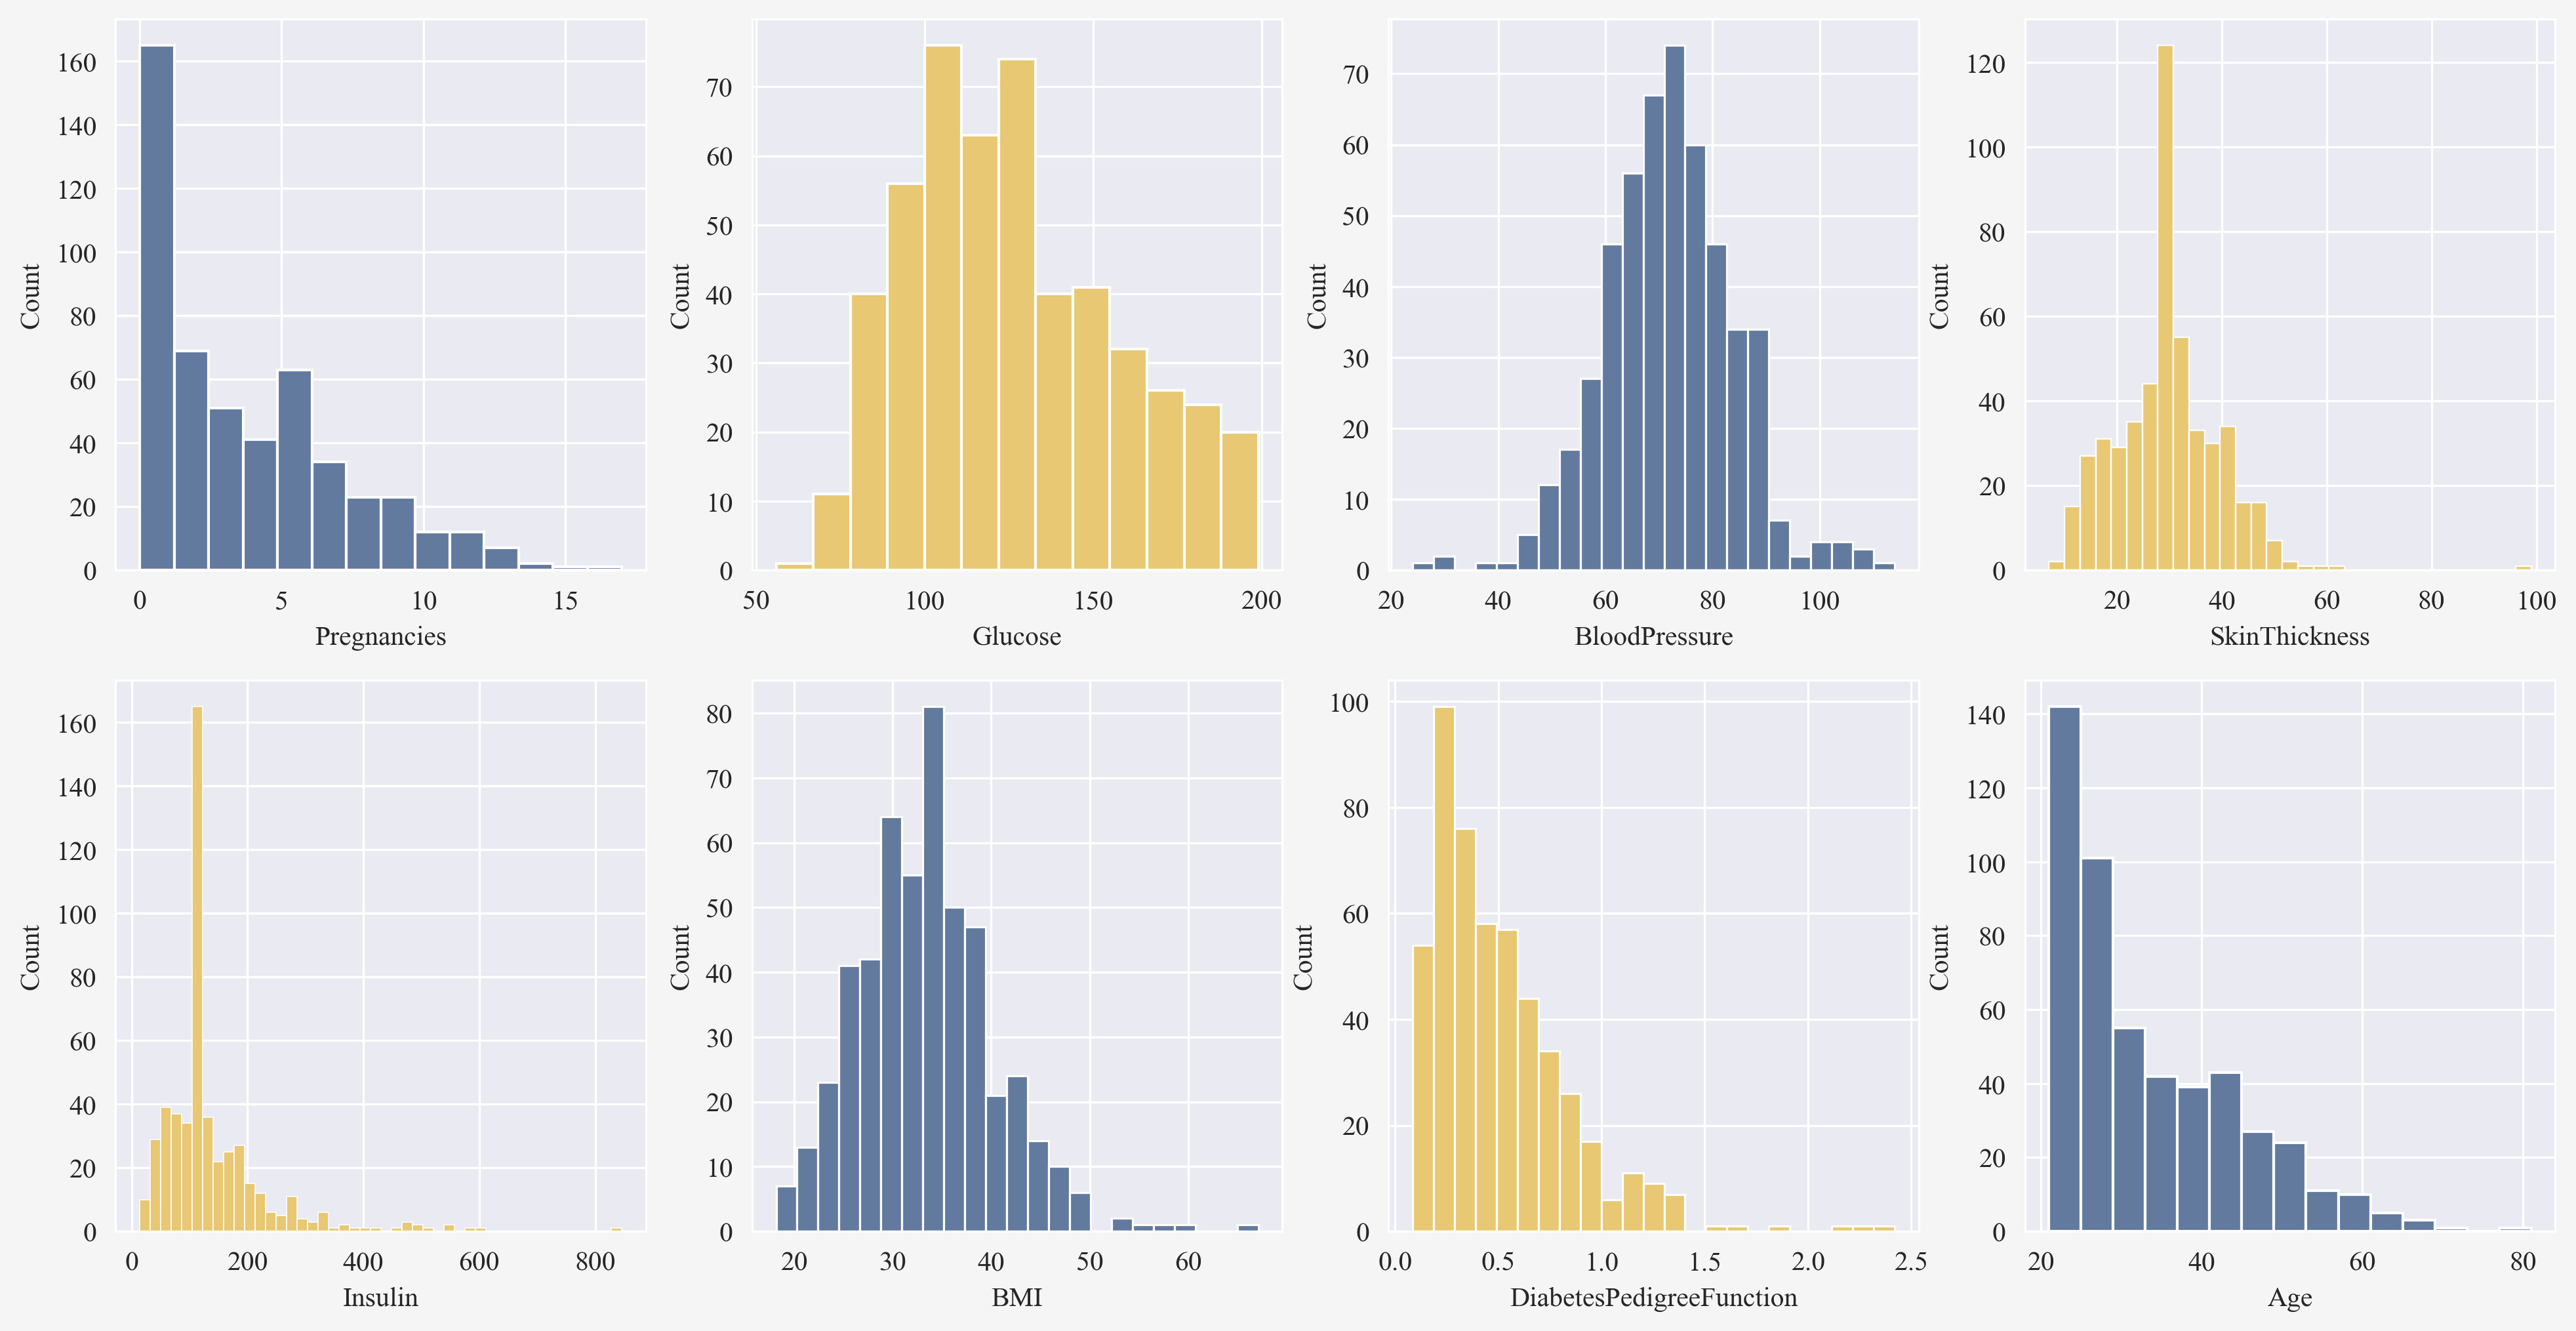

In [7]:
fig, ax = plt.subplots(2,4, figsize=(16,8), facecolor='whitesmoke', dpi=300)

sns.histplot(data['Pregnancies'], ax=ax[0,0], color='#637A9F', alpha=1)
sns.histplot(data['Glucose'], ax=ax[0,1], color='#E8C872', alpha=1)
sns.histplot(data['BloodPressure'], ax=ax[0,2], color='#637A9F', alpha=1)
sns.histplot(data['SkinThickness'], ax=ax[0,3], color='#E8C872', alpha=1)
sns.histplot(data['Insulin'], ax=ax[1,0], color='#E8C872', alpha=1)
sns.histplot(data['BMI'], ax=ax[1,1], color='#637A9F', alpha=1)
sns.histplot(data['DiabetesPedigreeFunction'], ax=ax[1,2], color='#E8C872', alpha=1)
sns.histplot(data['Age'], ax=ax[1,3], color='#637A9F', alpha=1);

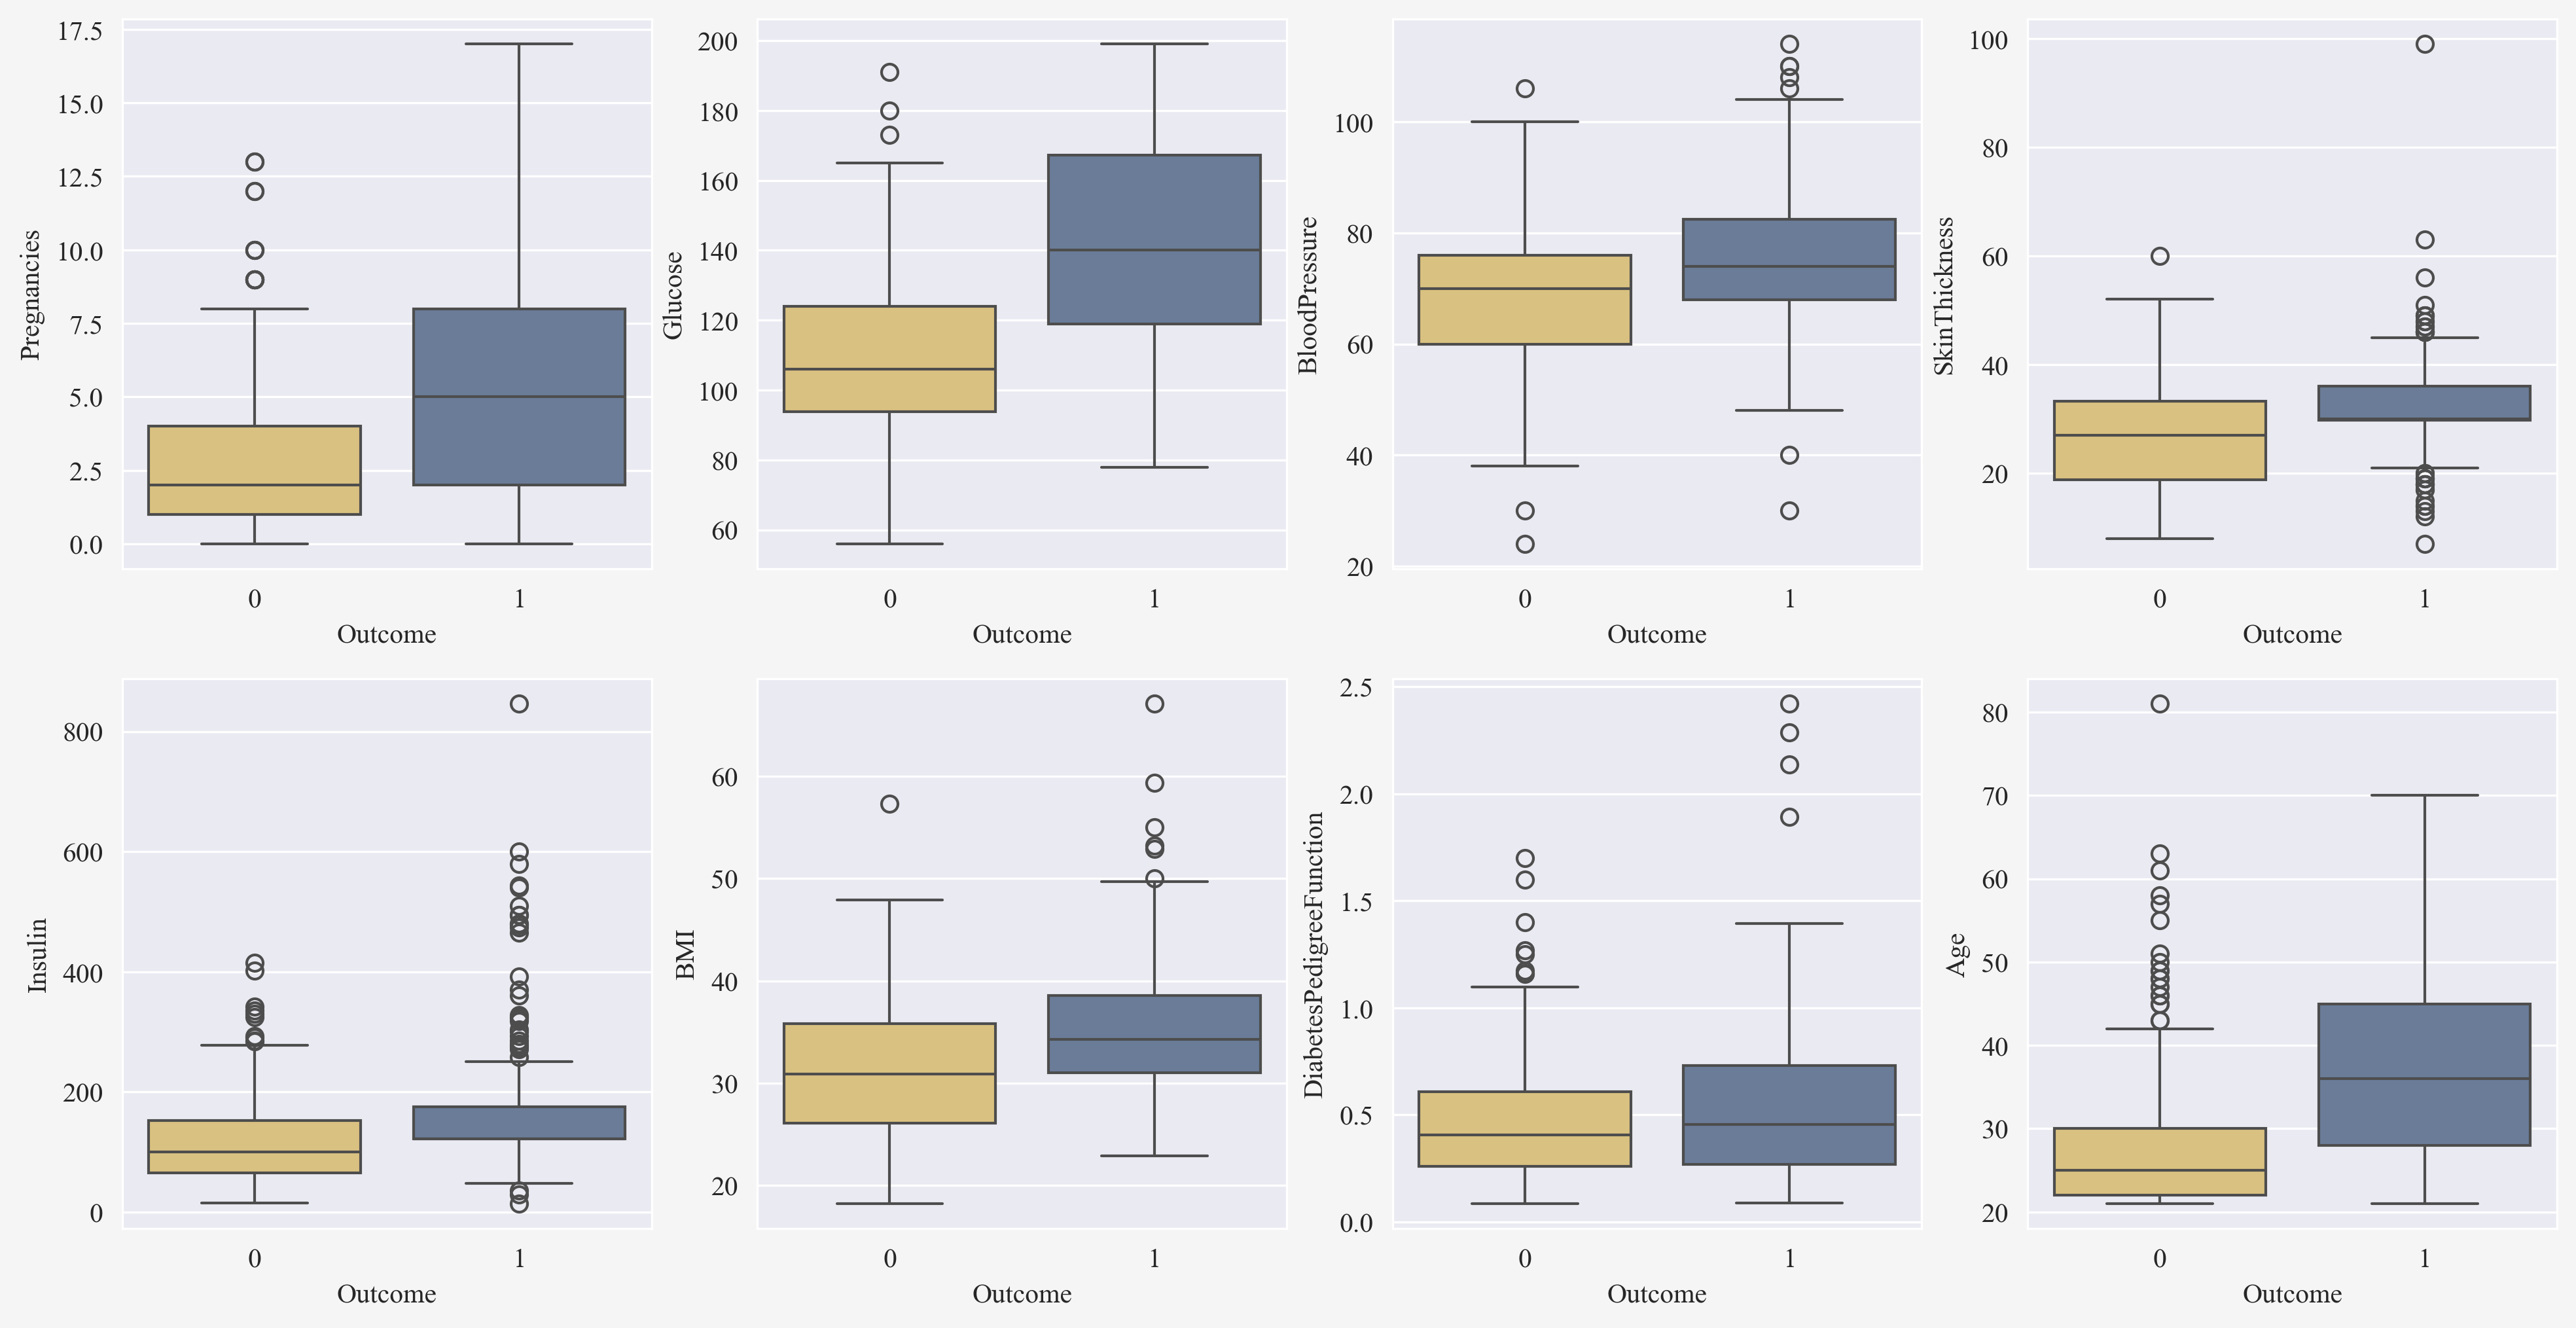

In [8]:
fig, ax = plt.subplots(2,4, figsize=(16,8), facecolor='whitesmoke', dpi=300)

sns.boxplot(x=data['Outcome'], y=data['Pregnancies'], ax=ax[0,0], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['Glucose'], ax=ax[0,1], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['BloodPressure'], ax=ax[0,2], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['SkinThickness'], ax=ax[0,3], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['Insulin'], ax=ax[1,0], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['BMI'], ax=ax[1,1], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['DiabetesPedigreeFunction'], ax=ax[1,2], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['Age'], ax=ax[1,3], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False);

### Univariate analysis after removing outliers

The dataset is not a very large one, so it would be better to avoid removing rows unnecessarily. We use the `Winsorization` method here. It mitigates the effects of outliers by replacing them with less extreme values

In [7]:
#90% Winsorization

cols = data.columns[:-1]

for col in cols:
    data[col] = pd.Series(winsorize(data[col],
                                    limits=[.05, .05])) 

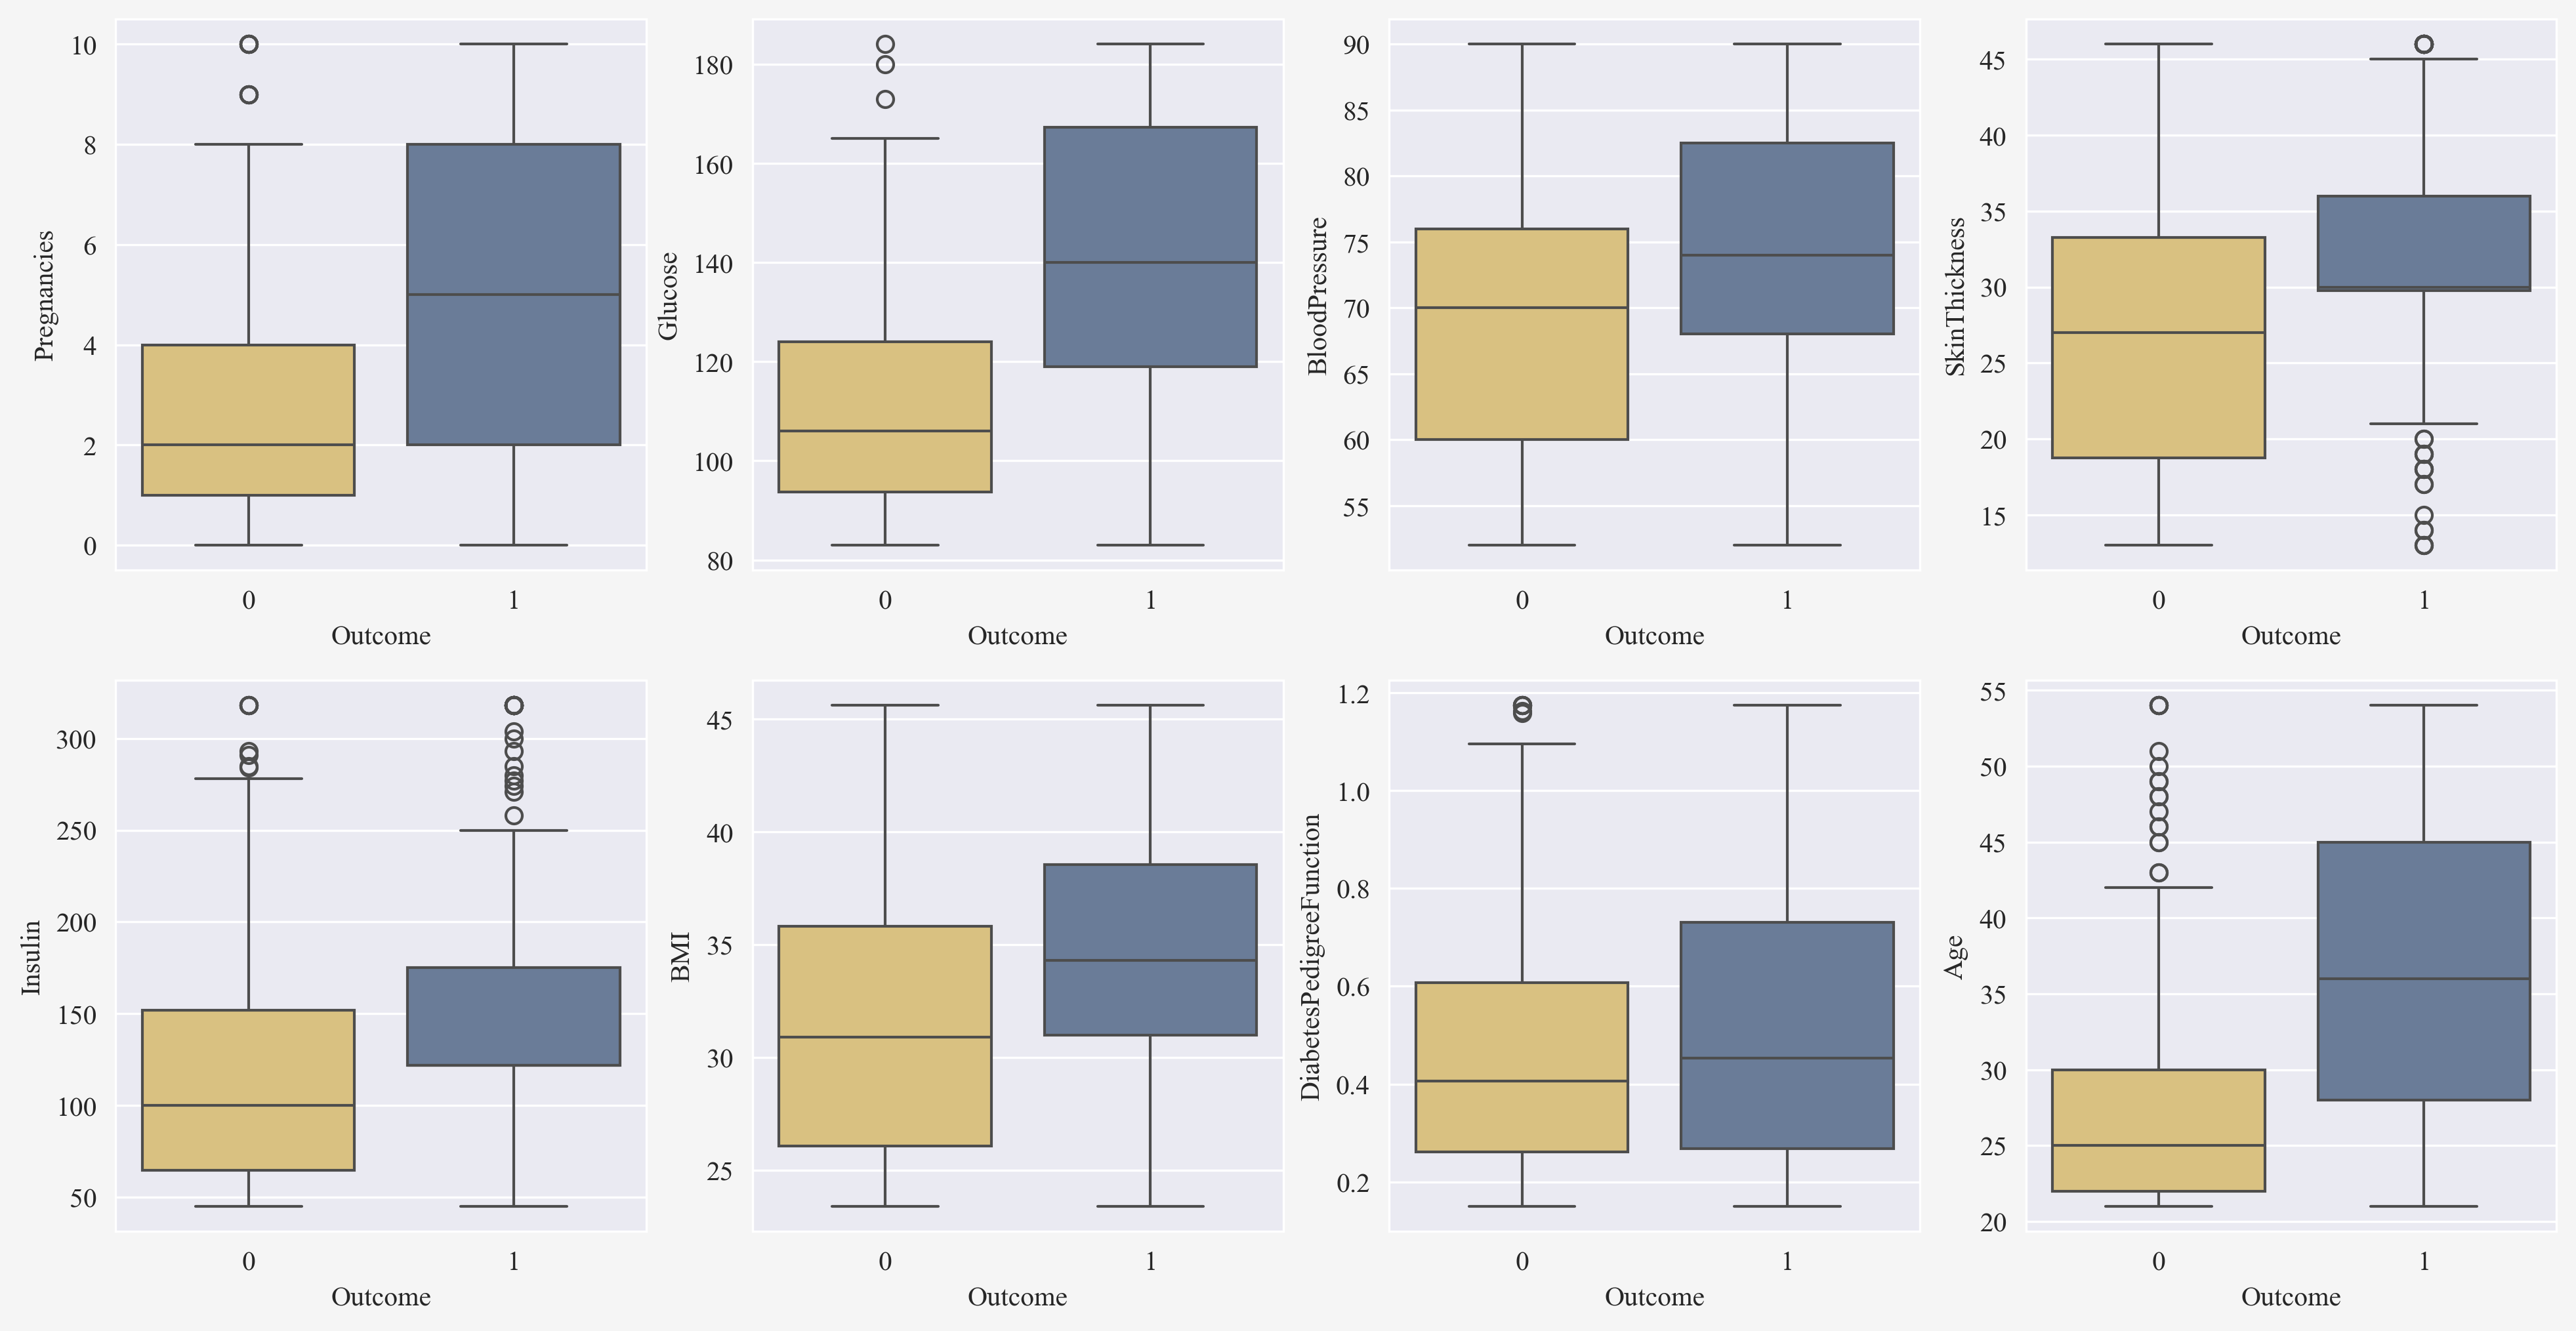

In [10]:
fig, ax = plt.subplots(2,4, figsize=(16,8), facecolor='whitesmoke', dpi=300)

sns.boxplot(x=data['Outcome'], y=data['Pregnancies'], ax=ax[0,0], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['Glucose'], ax=ax[0,1], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['BloodPressure'], ax=ax[0,2], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['SkinThickness'], ax=ax[0,3], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['Insulin'], ax=ax[1,0], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['BMI'], ax=ax[1,1], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['DiabetesPedigreeFunction'], ax=ax[1,2], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False)
sns.boxplot(x=data['Outcome'], y=data['Age'], ax=ax[1,3], hue=data['Outcome'], palette=['#E8C872','#637A9F'], legend=False);

### Bivariate analysis

<Figure size 1920x1440 with 0 Axes>

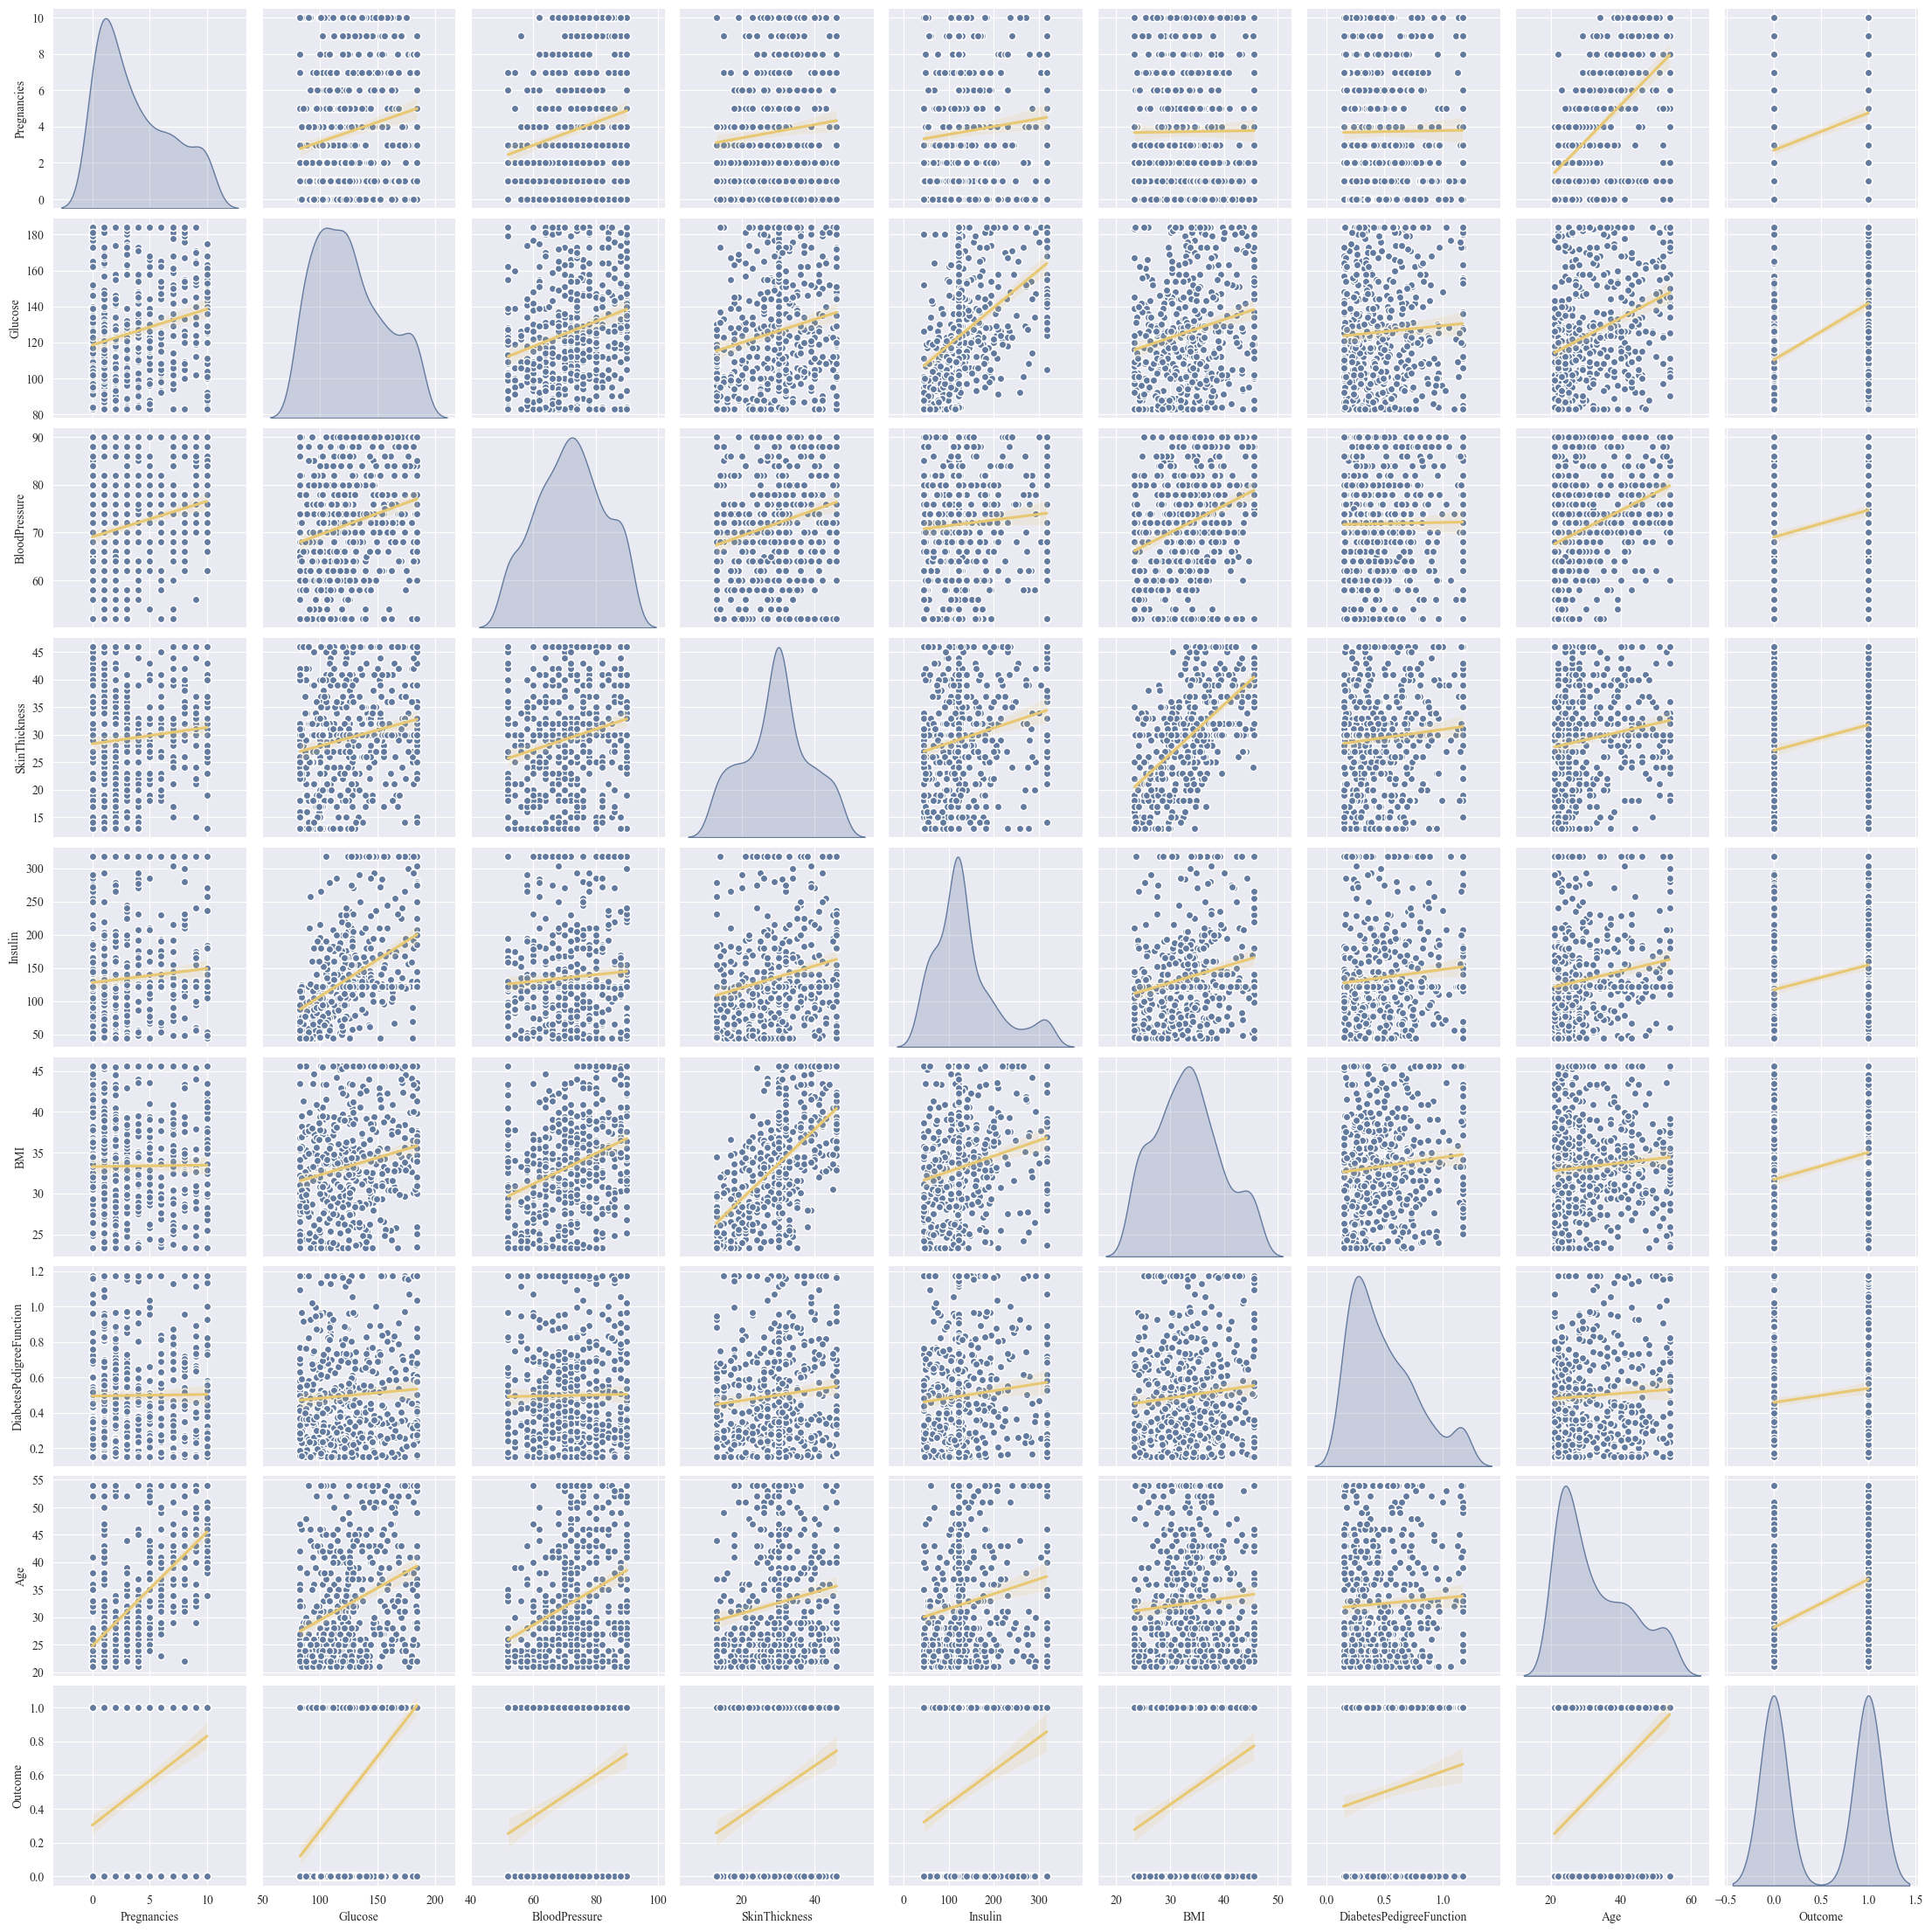

In [11]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.pairplot(data, kind='reg', plot_kws={'line_kws':{'color':'#E8C872'},
                                         'scatter_kws':{'edgecolor':'white','alpha':1},
                                         'color':'#637A9F'},
             diag_kws={'color':'#637A9F'},
             diag_kind='kde');

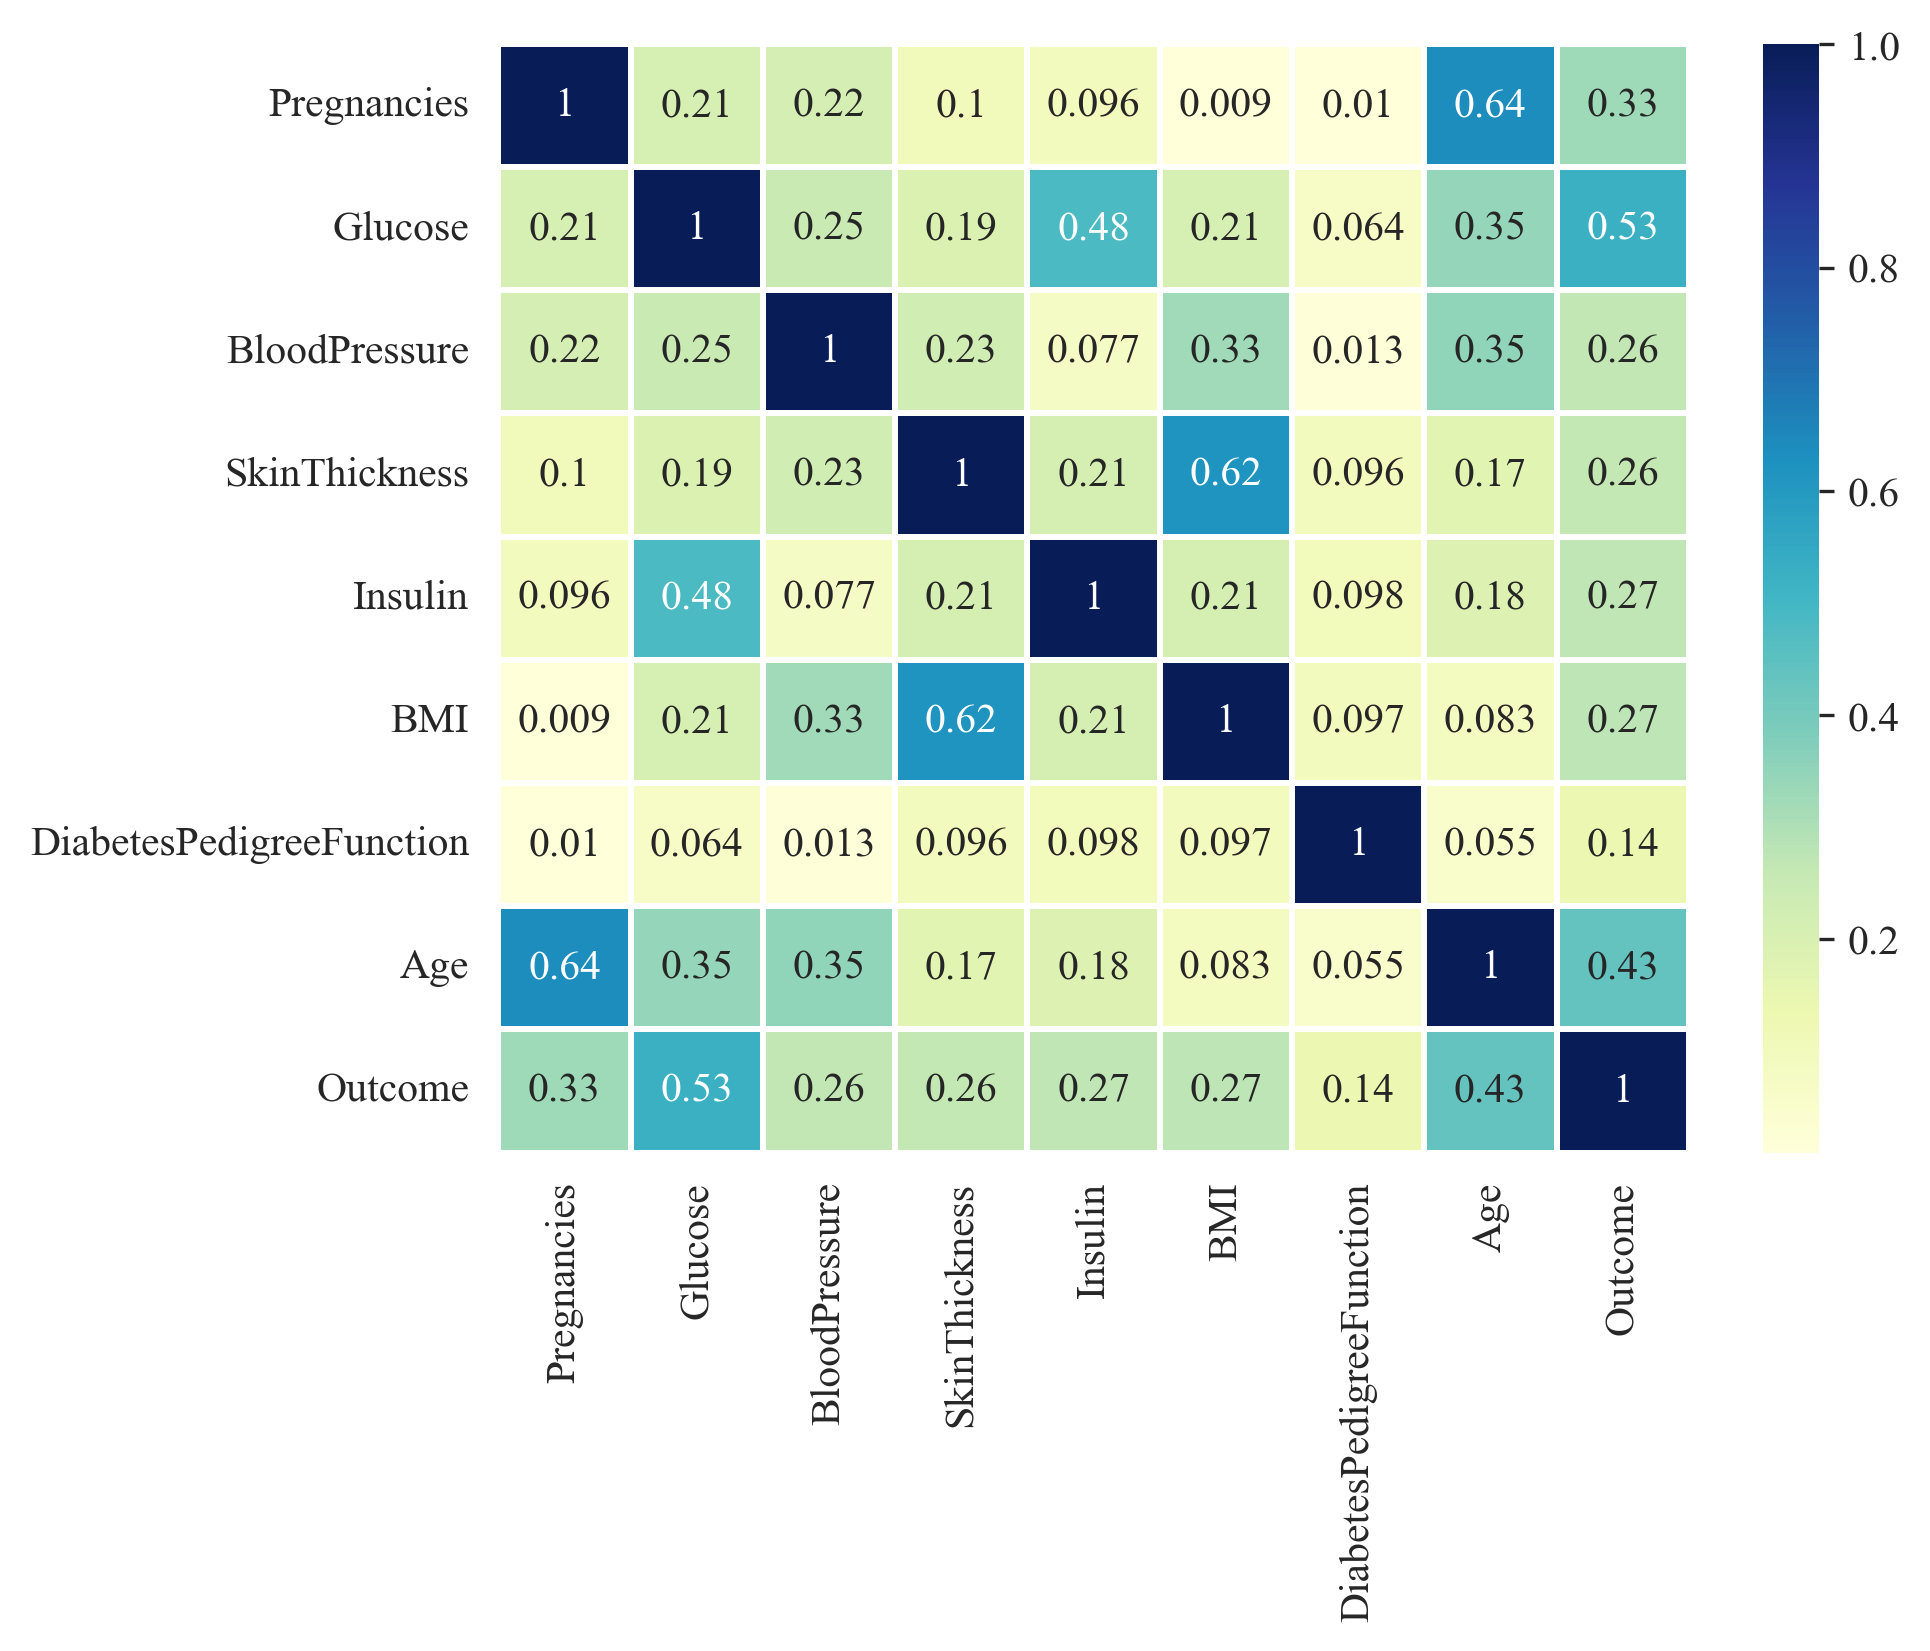

In [11]:
plt.figure(dpi=300)
sns.heatmap(data.corr(), annot=True, linewidth=1, cmap="YlGnBu");

&nbsp;

# Preprocessing

In [8]:
#Set seed for reproducibility
seed = 666

#70% train - 30% test splitting
train, test = train_test_split(data, test_size=.3, random_state=seed)

#Separating the target and input variables
X_train = train.drop(columns=['Outcome'])
y_train = train['Outcome']
X_test = test.drop(columns=['Outcome'])
y_test = test['Outcome']

#Using column transformer to transform specific columns independently
ct = ColumnTransformer([
    ('scaler', StandardScaler(), ['Pregnancies','Glucose','BloodPressure',
                                'Insulin','BMI','DiabetesPedigreeFunction','Age','SkinThickness'])],
    remainder='passthrough')


#Fit-transform on training data and transform on test data
train_scaled = ct.fit_transform(train)
test_scaled = ct.transform(test)

#Separating scaled input variables
X_train_scaled = train_scaled[:,:-1]
X_test_scaled = test_scaled[:,:-1]

#Splitting training set into estimation and validation sets for Logistic Regression!!!
est_scaled, val_scaled = train_test_split(train_scaled, test_size=.3, random_state=seed)
X_est_scaled = est_scaled[:,:-1]
X_val_scaled = val_scaled[:,:-1]
y_est = est_scaled[:,-1]
y_val = val_scaled[:,-1]

#Create a dataframe to store the model predictions
pred_train = pd.DataFrame({'y':y_train.reset_index(drop=True)})
pred_test = pd.DataFrame({'y':y_test.reset_index(drop=True)})
pred_probs = pd.DataFrame({})

&nbsp;

# 1. Logistic Regression

### Variations with different cut-off values

In [15]:
#Create empty lists to store metric values
specificities = []
sensitivities = []
accuracies = []
thresholds = np.linspace(0,1,101) #Cut-off values!

#Define logistic regression model
clf = LogisticRegression(random_state=seed)
clf.fit(X_est_scaled, y_est)

#Trying different values on validation set
for x in thresholds:
    y_val_probs = (clf.predict_proba(X_val_scaled) > x).astype('int')
    y_val_pred = y_val_probs[:,1]
    
    specificity = calc_specificity(y_val,y_val_pred)
    sensitivity = calc_sensitivity(y_val,y_val_pred)
    accuracy = np.round(accuracy_score(y_val,y_val_pred),5)

    specificities.append(specificity)
    sensitivities.append(sensitivity)
    accuracies.append(accuracy)

#Save the results in a dataframe
results = pd.DataFrame({'Cut-Off Value':thresholds,
                        'Specificity':specificities,
                        'Sensitivity':sensitivities,
                        'Accuracy':accuracies}).set_index('Cut-Off Value')

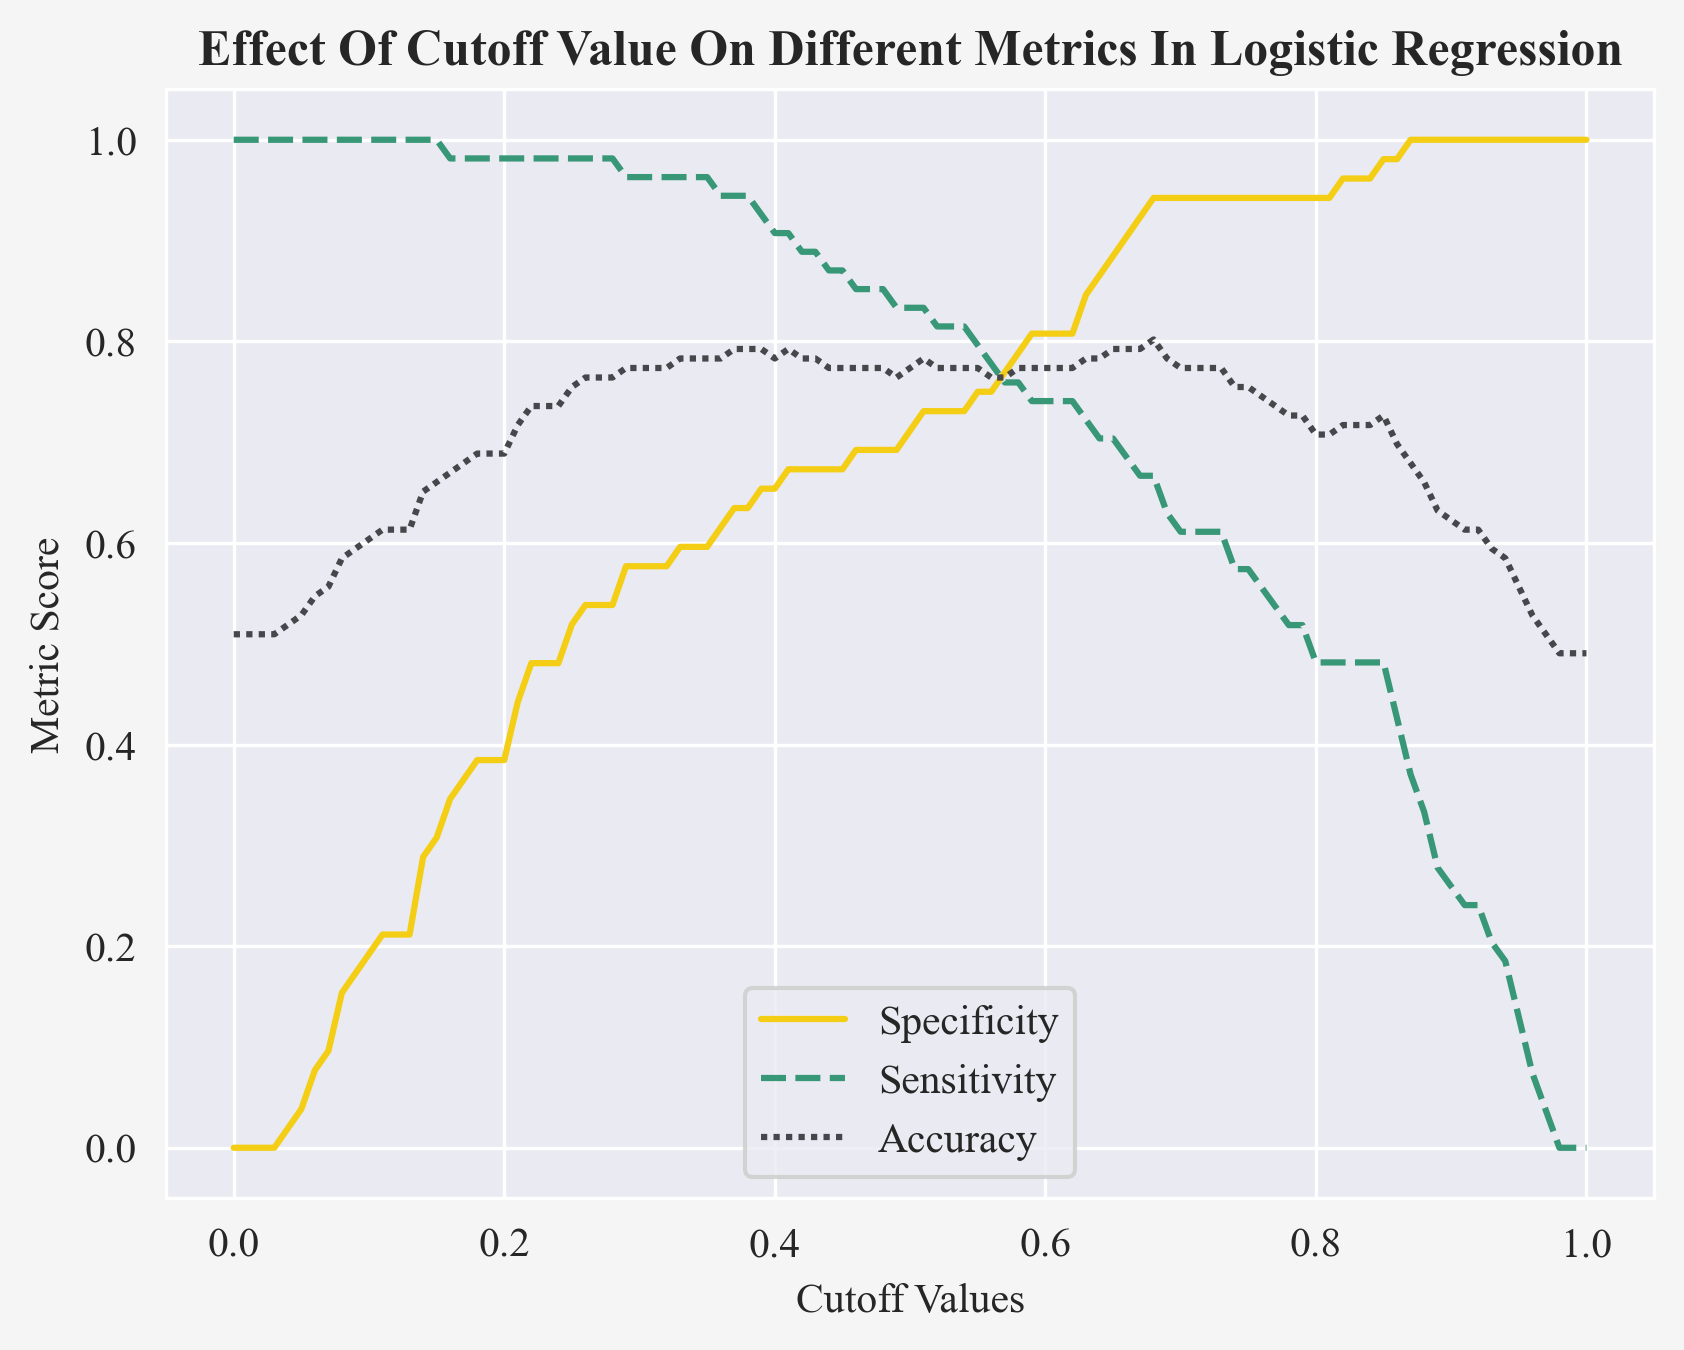

In [16]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.lineplot(results, palette=['#F4CE14','#379777','#45474B'])
plt.title('Effect of cutoff value on different metrics in logistic regression'.title(), weight='bold')
plt.xlabel('Cutoff Values')
plt.ylabel('Metric Score');

### Choosing the optimal cut-off value

In [17]:
values = results.values
values.sort(axis=1)

values_diff = np.diff(values)
sum_diffs = np.sum(values_diff, axis=1)
optimal_idx = np.where(sum_diffs==np.min(sum_diffs))[0][0]

print(results.iloc[optimal_idx])
best_cutoff = results.iloc[optimal_idx].name

Specificity    0.76923
Sensitivity    0.75926
Accuracy       0.76415
Name: 0.5700000000000001, dtype: float64


The point where the distance between Specificity, Sensitivity and Accuracy is minimum is equal to 0.57, which has an accuracy score of 0.76415, sensitivity score of 0.75926 and a specificity score of 0.76923.

### Getting the optimal value of C

In [18]:
clf = LogisticRegression(random_state=seed)

cv_params = {'C': np.linspace(0.01, 1, 100)}

gs = GridSearchCV(estimator=clf,
                  param_grid=cv_params,
                  scoring=['f1'],
                  refit='f1',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
best params: {'C': 0.24000000000000002}
best score: 0.7532738095238095


In [20]:
y_test_probs = (gs.predict_proba(X_test_scaled) > best_cutoff).astype('int')
y_test_pred = y_test_probs[:,1]; pred_test['LR'] = y_test_pred
pred_probs['LR'] = gs.predict_proba(X_test_scaled)[:,1]

y_train_probs = (gs.predict_proba(X_train_scaled) > best_cutoff).astype('int')
y_train_pred = y_train_probs[:,1]; pred_train['LR'] = y_train_pred

print("LR Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("LR Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("LR Train Precision:", precision_score(y_train, y_train_pred))
print("LR Test Precision:", precision_score(y_test, y_test_pred))
print("LR Train F1 Score:", f1_score(y_train, y_train_pred))
print("LR Test F1 Score:", f1_score(y_test, y_test_pred))
print("LR Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("LR Test Specificity:", calc_specificity(y_test, y_test_pred))
print("LR Test Misclass:", calc_misclass(y_test, y_test_pred))
print("LR Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

LR Train Accuracy: 0.75
LR Test Accuracy: 0.7894736842105263
LR Train Precision: 0.7971014492753623
LR Test Precision: 0.8472222222222222
LR Train F1 Score: 0.7142857142857143
LR Test F1 Score: 0.7922077922077922
LR Test Sensitivity: 0.7439
LR Test Specificity: 0.84286
LR Test Misclass: 0.21052631578947367
LR Confusion Matrix:
 [[59 11]
 [21 61]]


&nbsp;

# 2. Support Vector Machine

### Flat Decision Boundary

In [23]:
clf = SVC(kernel='linear', probability=True, random_state=seed)
clf.fit(X_train_scaled, y_train)

y_test_pred = clf.predict(X_test_scaled); pred_test['SVM_flat'] = y_test_pred
pred_probs['SVM_lin'] = clf.predict_proba(X_test_scaled)[:,1]
y_train_pred = clf.predict(X_train_scaled); pred_train['SVM_flat'] = y_train_pred

print("SVM Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("SVM Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("SVM Train Precision:", precision_score(y_train, y_train_pred))
print("SVM Test Precision:", precision_score(y_test, y_test_pred))
print("SVM Train F1 Score:", f1_score(y_train, y_train_pred))
print("SVM Test F1 Score:", f1_score(y_test, y_test_pred))
print("SVM Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("SVM Test Specificity:", calc_specificity(y_test, y_test_pred))
print("SVM Test Misclass:", calc_misclass(y_test, y_test_pred))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

SVM Train Accuracy: 0.7840909090909091
SVM Test Accuracy: 0.7960526315789473
SVM Train Precision: 0.79375
SVM Test Precision: 0.8311688311688312
SVM Train F1 Score: 0.7696969696969697
SVM Test F1 Score: 0.8050314465408805
SVM Test Sensitivity: 0.78049
SVM Test Specificity: 0.81429
SVM Test Misclass: 0.20394736842105263
SVM Confusion Matrix:
 [[57 13]
 [18 64]]


### Polynomial Transformation (Consider Interactions)

In [24]:
clf = SVC(kernel='poly', probability=True, random_state=seed)
clf.fit(X_train_scaled, y_train)

y_test_pred = clf.predict(X_test_scaled); pred_test['SVM_poly'] = y_test_pred
pred_probs['SVM_poly'] = clf.predict_proba(X_test_scaled)[:,1]
y_train_pred = clf.predict(X_train_scaled); pred_train['SVM_poly'] = y_train_pred

print("SVM Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("SVM Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("SVM Train Precision:", precision_score(y_train, y_train_pred))
print("SVM Test Precision:", precision_score(y_test, y_test_pred))
print("SVM Train F1 Score:", f1_score(y_train, y_train_pred))
print("SVM Test F1 Score:", f1_score(y_test, y_test_pred))
print("SVM Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("SVM Test Specificity:", calc_specificity(y_test, y_test_pred))
print("SVM Test Misclass:", calc_misclass(y_test, y_test_pred))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

SVM Train Accuracy: 0.84375
SVM Test Accuracy: 0.7960526315789473
SVM Train Precision: 0.9078014184397163
SVM Test Precision: 0.8591549295774648
SVM Train F1 Score: 0.8231511254019293
SVM Test F1 Score: 0.7973856209150327
SVM Test Sensitivity: 0.7439
SVM Test Specificity: 0.85714
SVM Test Misclass: 0.20394736842105263
SVM Confusion Matrix:
 [[60 10]
 [21 61]]


### Radial Basis Function

In [25]:
clf = SVC(kernel='rbf', probability=True, random_state=seed)

cv_params = {'gamma': np.linspace(0,1,101)}

gs = GridSearchCV(estimator=clf,
                  param_grid=cv_params,
                  scoring=['precision'],
                  refit='precision',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 101 candidates, totalling 303 fits
best params: {'gamma': 0.01}
best score: 0.7723622782446311


In [27]:
y_test_pred = gs.predict(X_test_scaled); pred_test['SVM_rbf'] = y_test_pred
pred_probs['SVM_rbf'] = gs.predict_proba(X_test_scaled)[:,1]
y_train_pred = gs.predict(X_train_scaled); pred_train['SVM_rbf'] = y_train_pred

print("SVM Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("SVM Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("SVM Train Precision:", precision_score(y_train, y_train_pred))
print("SVM Test Precision:", precision_score(y_test, y_test_pred))
print("SVM Train F1 Score:", f1_score(y_train, y_train_pred))
print("SVM Test F1 Score:", f1_score(y_test, y_test_pred))
print("SVM Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("SVM Test Specificity:", calc_specificity(y_test, y_test_pred))
print("SVM Test Misclass:", calc_misclass(y_test, y_test_pred))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

SVM Train Accuracy: 0.7897727272727273
SVM Test Accuracy: 0.7960526315789473
SVM Train Precision: 0.7758620689655172
SVM Test Precision: 0.8072289156626506
SVM Train F1 Score: 0.7848837209302325
SVM Test F1 Score: 0.8121212121212121
SVM Test Sensitivity: 0.81707
SVM Test Specificity: 0.77143
SVM Test Misclass: 0.20394736842105263
SVM Confusion Matrix:
 [[54 16]
 [15 67]]


&nbsp;

# 3. K-Nearest Neighbor

### Hyperparameter tuning the number of neighbors (`n_neighbors`)

In [28]:
clf = KNeighborsClassifier()

cv_params = {'n_neighbors': np.linspace(1,50,50).astype('int')}

gs = GridSearchCV(estimator=clf,
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
best params: {'n_neighbors': 13}
best score: 0.7724313627578808


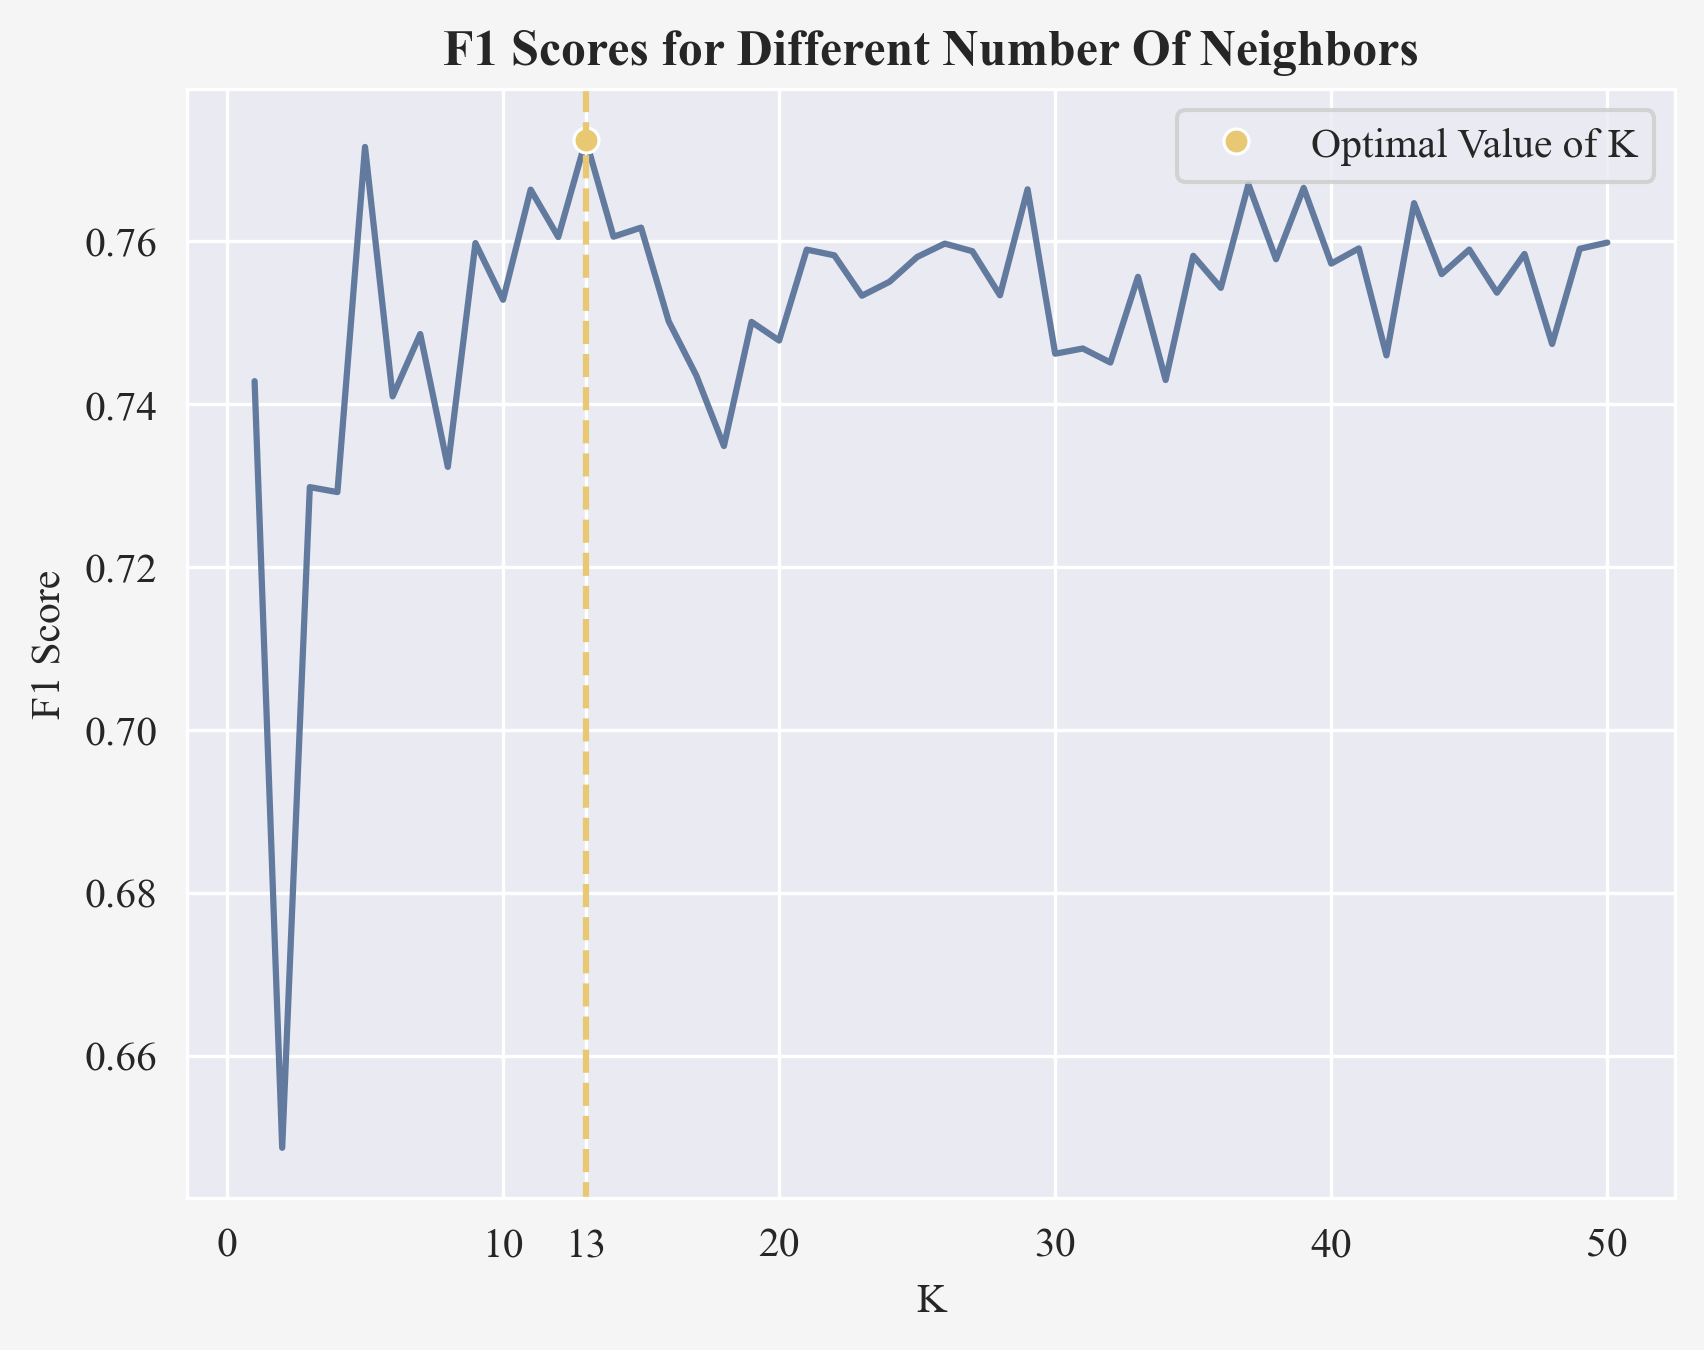

In [29]:
n_neighbors = np.linspace(1,50,50).astype('int')
accuracy = gs.cv_results_['mean_test_accuracy']
f1 = gs.cv_results_['mean_test_f1']
precision = gs.cv_results_['mean_test_precision']

plt.figure(facecolor='whitesmoke', dpi=300)
sns.lineplot(x=n_neighbors, y=f1, color='#637A9F')
sns.lineplot(x=gs.best_params_['n_neighbors'],
             y=f1[np.where(n_neighbors==gs.best_params_['n_neighbors'])],
             color='#E8C872', marker='o', linestyle='None', label='Optimal Value of K')
plt.axvline(gs.best_params_['n_neighbors'],1,0, linestyle='--', color='#E8C872')
plt.title('F1 Scores for Different Number Of Neighbors', weight='bold')
plt.xticks([0,gs.best_params_['n_neighbors'],10,20,30,40,50])
plt.xlabel('K')
plt.ylabel('F1 Score');

In [30]:
y_test_pred = gs.predict(X_test_scaled); pred_test['KNN'] = y_test_pred
pred_probs['KNN'] = gs.predict_proba(X_test_scaled)[:,1]
y_train_pred = gs.predict(X_train_scaled); pred_train['KNN'] = y_train_pred

print("KNN Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("KNN Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("KNN Train Precision:", precision_score(y_train, y_train_pred))
print("KNN Test Precision:", precision_score(y_test, y_test_pred))
print("KNN Train F1 Score:", f1_score(y_train, y_train_pred))
print("KNN Test F1 Score:", f1_score(y_test, y_test_pred))
print("KNN Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("KNN Test Specificity:", calc_specificity(y_test, y_test_pred))
print("KNN Test Misclass:", calc_misclass(y_test, y_test_pred))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

KNN Train Accuracy: 0.7982954545454546
KNN Test Accuracy: 0.7894736842105263
KNN Train Precision: 0.7928994082840237
KNN Test Precision: 0.8048780487804879
KNN Train F1 Score: 0.7905604719764012
KNN Test F1 Score: 0.8048780487804879
KNN Test Sensitivity: 0.80488
KNN Test Specificity: 0.77143
KNN Test Misclass: 0.21052631578947367
KNN Confusion Matrix:
 [[54 16]
 [16 66]]


&nbsp;

# 4. Gaussian Naïve Bayes

In [31]:
clf = GaussianNB()

clf.fit(X_train_scaled, y_train)
y_test_pred = clf.predict(X_test_scaled); pred_test['NB'] = y_test_pred
pred_probs['NB'] = clf.predict_proba(X_test_scaled)[:,1]
y_train_pred = clf.predict(X_train_scaled); pred_train['NB'] = y_train_pred

print("NB Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("NB Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("NB Train Precision:", precision_score(y_train, y_train_pred))
print("NB Test Precision:", precision_score(y_test, y_test_pred))
print("NB Train F1 Score:", f1_score(y_train, y_train_pred))
print("NB Test F1 Score:", f1_score(y_test, y_test_pred))
print("NB Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("NB Test Specificity:", calc_specificity(y_test, y_test_pred))
print("NB Test Misclass:", calc_misclass(y_test, y_test_pred))
print("NB Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

NB Train Accuracy: 0.7897727272727273
NB Test Accuracy: 0.7960526315789473
NB Train Precision: 0.7790697674418605
NB Test Precision: 0.8148148148148148
NB Train F1 Score: 0.783625730994152
NB Test F1 Score: 0.8098159509202454
NB Test Sensitivity: 0.80488
NB Test Specificity: 0.78571
NB Test Misclass: 0.20394736842105263
NB Confusion Matrix:
 [[55 15]
 [16 66]]


&nbsp;

# 5. Linear Discriminant Analysis (LDA)

In [32]:
clf = LinearDiscriminantAnalysis()

clf.fit(X_train_scaled, y_train)

y_test_pred = clf.predict(X_test_scaled); pred_test['LDA'] = y_test_pred
pred_probs['LDA'] = clf.predict_proba(X_test_scaled)[:,1]
y_train_pred = clf.predict(X_train_scaled); pred_train['LDA'] = y_train_pred

print("LDA Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("LDA Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("LDA Train Precision:", precision_score(y_train, y_train_pred))
print("LDA Test Precision:", precision_score(y_test, y_test_pred))
print("LDA Train F1 Score:", f1_score(y_train, y_train_pred))
print("LDA Test F1 Score:", f1_score(y_test, y_test_pred))
print("LDA Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("LDA Test Specificity:", calc_specificity(y_test, y_test_pred))
print("LDA Test Misclass:", calc_misclass(y_test, y_test_pred))
print("LDA Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

LDA Train Accuracy: 0.7613636363636364
LDA Test Accuracy: 0.7960526315789473
LDA Train Precision: 0.7756410256410257
LDA Test Precision: 0.84
LDA Train F1 Score: 0.7423312883435583
LDA Test F1 Score: 0.802547770700637
LDA Test Sensitivity: 0.76829
LDA Test Specificity: 0.82857
LDA Test Misclass: 0.20394736842105263
LDA Confusion Matrix:
 [[58 12]
 [19 63]]


&nbsp;

# 6. Quadratic Discriminant Analysis (QDA)

In [33]:
clf = QuadraticDiscriminantAnalysis()

clf.fit(X_train_scaled, y_train)

y_test_pred = clf.predict(X_test_scaled); pred_test['QDA'] = y_test_pred
pred_probs['QDA'] = clf.predict_proba(X_test_scaled)[:,1]
y_train_pred = clf.predict(X_train_scaled); pred_train['QDA'] = y_train_pred

print("QDA Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("QDA Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("QDA Train Precision:", precision_score(y_train, y_train_pred))
print("QDA Test Precision:", precision_score(y_test, y_test_pred))
print("QDA Train F1 Score:", f1_score(y_train, y_train_pred))
print("QDA Test F1 Score:", f1_score(y_test, y_test_pred))
print("QDA Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("QDA Test Specificity:", calc_specificity(y_test, y_test_pred))
print("QDA Test Misclass:", calc_misclass(y_test, y_test_pred))
print("QDA Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

QDA Train Accuracy: 0.8011363636363636
QDA Test Accuracy: 0.7828947368421053
QDA Train Precision: 0.8164556962025317
QDA Test Precision: 0.8266666666666667
QDA Train F1 Score: 0.7865853658536586
QDA Test F1 Score: 0.7898089171974523
QDA Test Sensitivity: 0.7561
QDA Test Specificity: 0.81429
QDA Test Misclass: 0.21710526315789475
QDA Confusion Matrix:
 [[57 13]
 [20 62]]


&nbsp;

# 7. Decision Tree

### Hyperparameter tuning `max_depth` and `min_samples_split`

In [34]:
clf = DecisionTreeClassifier(random_state=seed)

cv_params = {'max_depth': np.linspace(1,100,100).astype('int'),
             'min_samples_split': np.linspace(2,40,39).astype('int')}

gs = GridSearchCV(estimator=clf,
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 3900 candidates, totalling 11700 fits
best params: {'max_depth': 5, 'min_samples_split': 34}
best score: 0.8048440065681445


### Hyperparameter tuning `max_features` and `min_samples_leaf`

In [35]:
max_depth = gs.best_params_['max_depth']
min_samples_split = gs.best_params_['min_samples_split']

cv_params = {'min_samples_leaf': np.linspace(1,20,20).astype('int'),
             'max_features': list(range(1,X_train_scaled.shape[1]+1))}

gs = GridSearchCV(estimator=DecisionTreeClassifier(max_depth=max_depth,
                                                   min_samples_split=min_samples_split,
                                                   random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 160 candidates, totalling 480 fits
best params: {'max_features': 6, 'min_samples_leaf': 15}
best score: 0.8314669809996912


### Hyperparameter tuning `min_weight_fraction_leaf` and `ccp_alpha`

In [36]:
max_features = gs.best_params_['max_features']
min_samples_leaf = gs.best_params_['min_samples_leaf']

cv_params = {'ccp_alpha': np.linspace(0,1,101),
             'min_weight_fraction_leaf': np.linspace(0,0.5,51)}

gs = GridSearchCV(estimator=DecisionTreeClassifier(max_depth=max_depth,
                                                   min_samples_split=min_samples_split,
                                                   max_features=max_features,
                                                   min_samples_leaf=min_samples_leaf,
                                                   random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 5151 candidates, totalling 15453 fits
best params: {'ccp_alpha': 0.0, 'min_weight_fraction_leaf': 0.0}
best score: 0.8314669809996912


In [37]:
y_test_pred = gs.predict(X_test_scaled); pred_test['DT'] = y_test_pred
pred_probs['DT'] = gs.predict_proba(X_test_scaled)[:,1]
y_train_pred = gs.predict(X_train_scaled); pred_train['DT'] = y_train_pred

print("DT Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("DT Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("DT Train Precision:", precision_score(y_train, y_train_pred))
print("DT Test Precision:", precision_score(y_test, y_test_pred))
print("DT Train F1 Score:", f1_score(y_train, y_train_pred))
print("DT Test F1 Score:", f1_score(y_test, y_test_pred))
print("DT Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("DT Test Specificity:", calc_specificity(y_test, y_test_pred))
print("DT Test Misclass:", calc_misclass(y_test, y_test_pred))
print("DT Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

DT Train Accuracy: 0.8494318181818182
DT Test Accuracy: 0.8223684210526315
DT Train Precision: 0.8874172185430463
DT Test Precision: 0.8873239436619719
DT Train F1 Score: 0.8348909657320872
DT Test F1 Score: 0.8235294117647058
DT Test Sensitivity: 0.76829
DT Test Specificity: 0.88571
DT Test Misclass: 0.17763157894736842
DT Confusion Matrix:
 [[62  8]
 [19 63]]


&nbsp;

# 8. Random Forest

### Hyperparameter tuning `n_estimators` and `min_samples_split`

In [38]:
cv_params = {'n_estimators': np.linspace(1,50,50).astype(int),
             'min_samples_split': np.linspace(2,10,9).astype(int)}

gs = GridSearchCV(estimator=RandomForestClassifier(random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 450 candidates, totalling 1350 fits
best params: {'min_samples_split': 6, 'n_estimators': 18}
best score: 0.8485761505212306


### Hyperparameter tuning `max_features` and `max_depth`

In [39]:
n_estimators = gs.best_params_['n_estimators']
min_samples_split = gs.best_params_['min_samples_split']

cv_params = {'max_features': list(range(1, X_train_scaled.shape[1] + 1)),
             'max_depth': np.linspace(1,50,50).astype(int)}

gs = GridSearchCV(estimator=RandomForestClassifier(n_estimators=n_estimators,
                                                   min_samples_split=min_samples_split,
                                                   random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
best params: {'max_depth': 12, 'max_features': 2}
best score: 0.8485761505212306


### Hyperparameter tuning `min_samples_leaf`

In [40]:
max_depth = gs.best_params_['max_depth']
max_features = gs.best_params_['max_features']

cv_params = {'min_samples_leaf': np.linspace(1, 10, 10).astype(int)}

gs = GridSearchCV(estimator=RandomForestClassifier(n_estimators=n_estimators,
                                                   min_samples_split=min_samples_split,
                                                   max_depth=max_depth,
                                                   max_features=max_features,
                                                   random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
best params: {'min_samples_leaf': 1}
best score: 0.8485761505212306


In [41]:
y_test_pred = gs.predict(X_test_scaled); pred_test['RF'] = y_test_pred
pred_probs['RF'] = gs.predict_proba(X_test_scaled)[:,1]
y_train_pred = gs.predict(X_train_scaled); pred_train['RF'] = y_train_pred

print("RF Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("RF Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("RF Train Precision:", precision_score(y_train, y_train_pred))
print("RF Test Precision:", precision_score(y_test, y_test_pred))
print("RF Train F1 Score:", f1_score(y_train, y_train_pred))
print("RF Test F1 Score:", f1_score(y_test, y_test_pred))
print("RF Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("RF Test Specificity:", calc_specificity(y_test, y_test_pred))
print("RF Test Misclass:", calc_misclass(y_test, y_test_pred))
print("RF Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

RF Train Accuracy: 0.9715909090909091
RF Test Accuracy: 0.8618421052631579
RF Train Precision: 0.9819277108433735
RF Test Precision: 0.8588235294117647
RF Train F1 Score: 0.9702380952380952
RF Test F1 Score: 0.874251497005988
RF Test Sensitivity: 0.89024
RF Test Specificity: 0.82857
RF Test Misclass: 0.13815789473684212
RF Confusion Matrix:
 [[58 12]
 [ 9 73]]


&nbsp;

# 9. eXtreme Gradient Boosting

### tune the `max_depth` and `min_child_weight` on a wide range of values

In [9]:
cv_params = {'max_depth': [2,4,6,8],
             'min_child_weight': [1,3,5,7]}

gs = GridSearchCV(estimator=xgb.XGBClassifier(random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
best params: {'max_depth': 4, 'min_child_weight': 7}
best score: 0.8165204678362573


### Refine `max_depth` and `min_child_weight` on a smaller grid of values

In [10]:
max_depth = gs.best_params_['max_depth']
min_child_weight = gs.best_params_['min_child_weight']

cv_params = {'max_depth': [max_depth-1, max_depth, max_depth+1], 
             'min_child_weight': [min_child_weight-1, min_child_weight-0.5, min_child_weight, min_child_weight+0.5, min_child_weight+1]}

gs = GridSearchCV(estimator=xgb.XGBClassifier(random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='precision',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
best params: {'max_depth': 4, 'min_child_weight': 6.5}
best score: 0.8278293773649811


### Hyperparameter tuning `gamma`

In [11]:
max_depth = gs.best_params_['max_depth']
min_child_weight = gs.best_params_['min_child_weight']

cv_params = {'gamma': [i/10.0 for i in range(1,10,2)]}

gs = GridSearchCV(estimator=xgb.XGBClassifier(max_depth=max_depth,
                                              min_child_weight=min_child_weight,
                                              random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
best params: {'gamma': 0.9}
best score: 0.8327721477607061


### tune both `colsample_bytree` and `subsample` on 10% intervals from 60% to 100%

In [12]:
gamma = gs.best_params_['gamma']

cv_params = {'subsample': [i/10.0 for i in range(6,11)],
             'colsample_bytree': [i/10.0 for i in range(6,11)]}

gs = GridSearchCV(estimator=xgb.XGBClassifier(max_depth=max_depth,
                                              min_child_weight=min_child_weight,
                                              gamma=gamma,
                                              random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
best params: {'colsample_bytree': 1.0, 'subsample': 1.0}
best score: 0.8327721477607061


### Retune `colsample_bytree` and `subsample` with a smaller grid of values

In [13]:
subsample = gs.best_params_['subsample']
colsample_bytree = gs.best_params_['colsample_bytree']

cv_params = {'subsample': [i/100.0 for i in range(int((subsample-0.1)*100.0), min(int((subsample+0.1)*100),105) , 5)],
             'colsample_bytree': [i/100.0 for i in range(int((colsample_bytree-0.1)*100.0), min(int((subsample+0.1)*100),105), 5)]}

gs = GridSearchCV(estimator=xgb.XGBClassifier(max_depth=max_depth,
                                              min_child_weight=min_child_weight,
                                              gamma=gamma,
                                              random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
best params: {'colsample_bytree': 1.0, 'subsample': 1.0}
best score: 0.8327721477607061


### tuning `reg_alpha` and `reg_lambda` parameters

`reg_alpha` controls L1 regularisation and `reg_lambda` controls L2 regularisation.

In [14]:
subsample = gs.best_params_['subsample']

cv_params = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100], 
             'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]}

gs = GridSearchCV(estimator=xgb.XGBClassifier(max_depth=max_depth,
                                              min_child_weight=min_child_weight,
                                              gamma=gamma,
                                              colsample_bytree=colsample_bytree,
                                              subsample=subsample,
                                              random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
best params: {'reg_alpha': 1e-05, 'reg_lambda': 1}
best score: 0.8327721477607061


### Refine `reg_alpha` and `reg_lambda` on a smaller grid of values

In [15]:
reg_alpha = gs.best_params_['reg_alpha']
reg_lambda = gs.best_params_['reg_lambda']

cv_params = {'reg_alpha': [reg_alpha*0.2, reg_alpha*0.5, reg_alpha, reg_alpha*2, reg_alpha*5], 
             'reg_lambda': [reg_lambda*0.2, reg_lambda*0.5, reg_lambda, reg_lambda*2, reg_lambda*5]}

gs = GridSearchCV(estimator=xgb.XGBClassifier(max_depth=max_depth,
                                              min_child_weight=min_child_weight,
                                              gamma=gamma,
                                              colsample_bytree=colsample_bytree,
                                              subsample=subsample,
                                              random_state=seed),
                  param_grid=cv_params,
                  scoring=['accuracy','f1','precision'],
                  refit='f1',
                  cv=3,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
best params: {'reg_alpha': 2.0000000000000003e-06, 'reg_lambda': 1}
best score: 0.8327721477607061


### Setting regularisation parameters

In [16]:
reg_alpha = gs.best_params_['reg_alpha']
reg_lambda = gs.best_params_['reg_lambda']

parameters = {'objective':'binary:logistic',
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'gamma': gamma,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'random_state': seed}

### Storing input data in a `DMatrix` object

In [17]:
train_DMatrix = xgb.DMatrix(data = X_train_scaled, label = y_train)
test_DMatrix = xgb.DMatrix(data = X_test_scaled, label = y_test)

### tuning `num_boost_round`

number of trees to build will be passed as a standalone argument to the training method.

In [18]:
learning_rate = 0.05
parameters['eta'] = learning_rate

num_boost_round = 3000
early_stopping_rounds = 20

xgbCV = xgb.cv(
    params = parameters, 
    dtrain = train_DMatrix, 
    num_boost_round = num_boost_round,
    nfold = 3,
    metrics = {'error'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = 0,
    seed = seed     
)

### Model Errors for Different Number of Trees

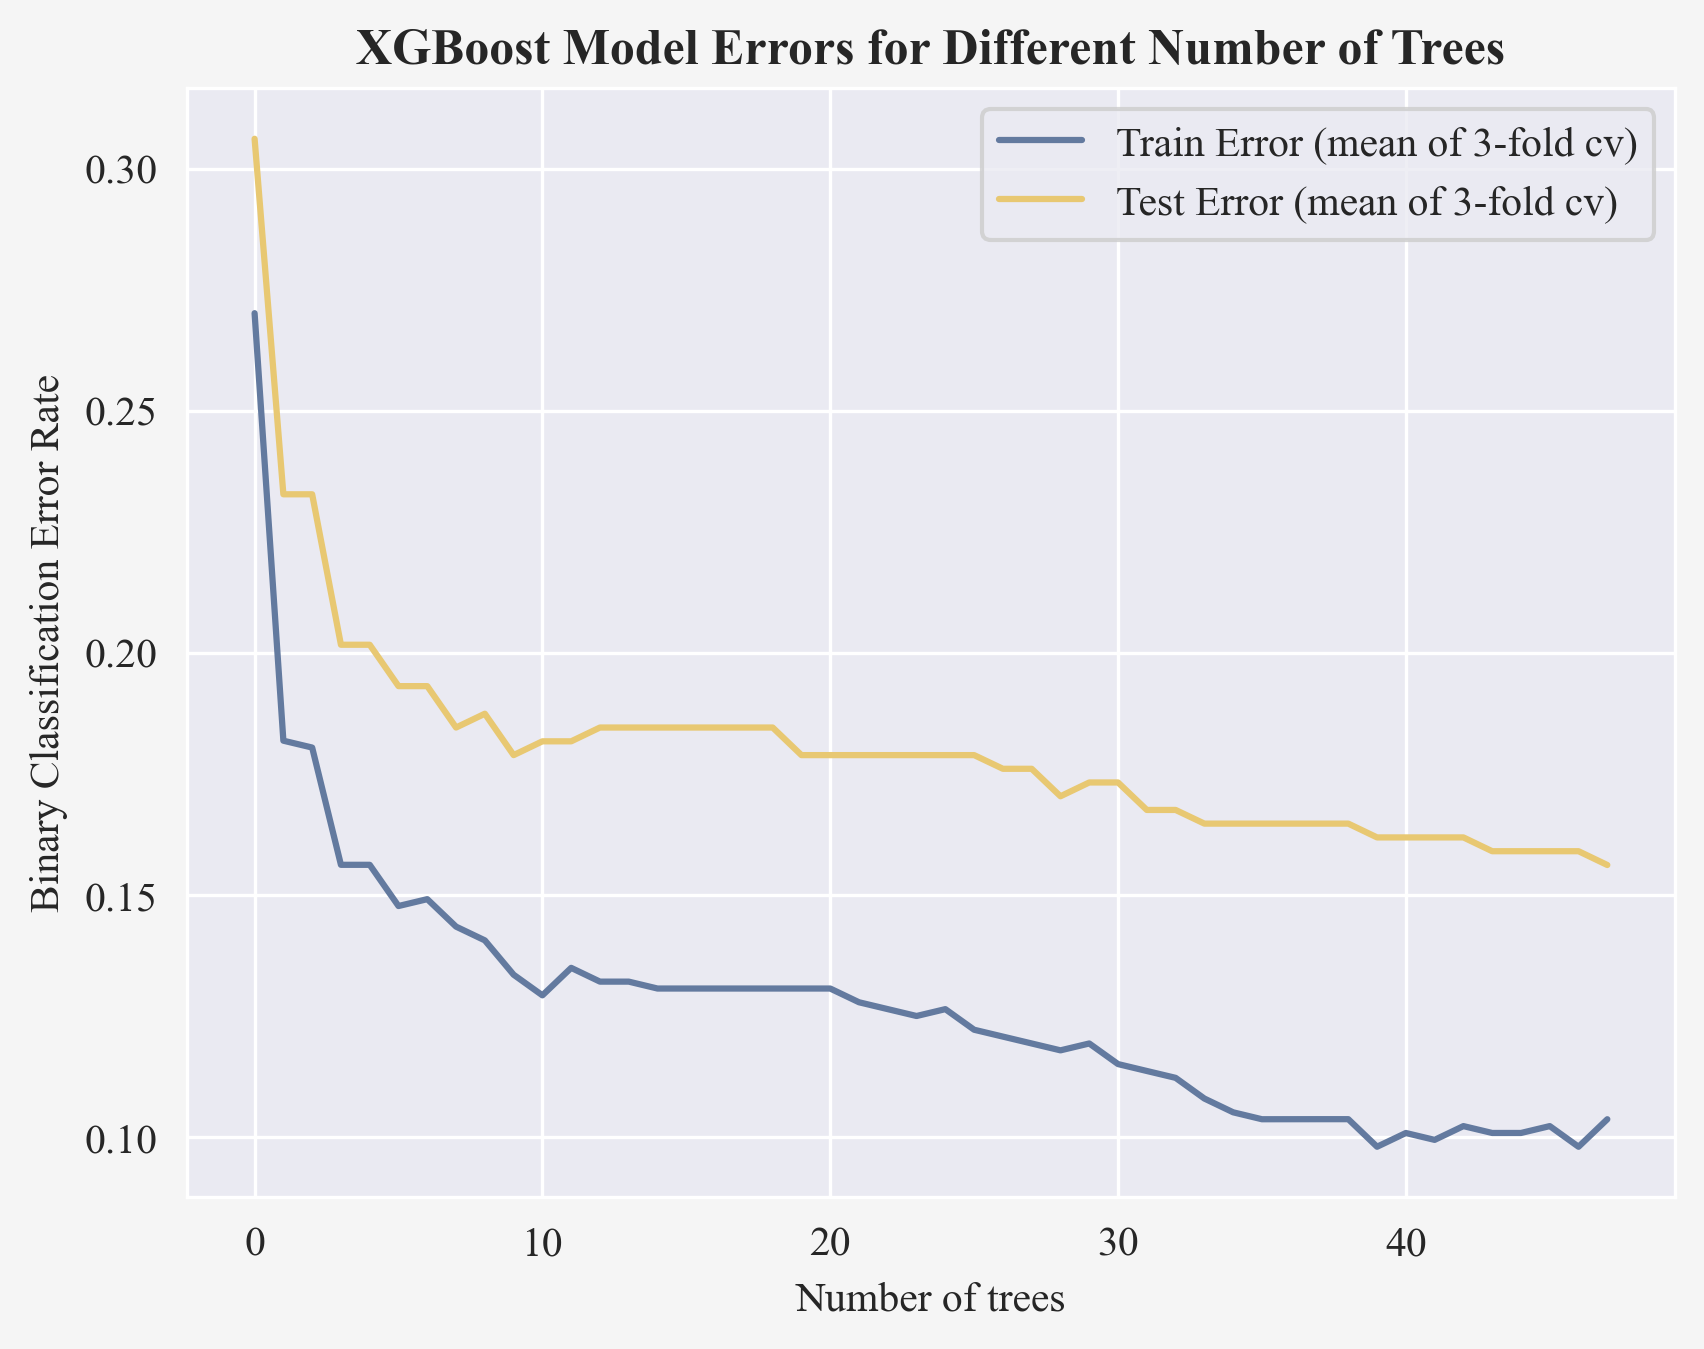

In [19]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.lineplot(xgbCV['train-error-mean'], label='Train Error (mean of 3-fold cv)', color='#637A9F')
sns.lineplot(xgbCV['test-error-mean'], label='Test Error (mean of 3-fold cv)', color='#E8C872')
plt.title('XGBoost Model Errors for Different Number of Trees', weight='bold')
plt.xlabel('Number of trees')
plt.ylabel('Binary Classification Error Rate');

In [21]:
parameters['num_boost_round'] = len(xgbCV)

clf = xgb.XGBClassifier(max_depth=parameters['max_depth'],
                        min_child_weight=parameters['min_child_weight'],
                        gamma=parameters['gamma'],
                        subsample=parameters['subsample'],
                        colsample_bytree=parameters['colsample_bytree'],
                        reg_alpha=parameters['reg_alpha'],
                        reg_lambda=parameters['reg_lambda'],
                        random_state=parameters['random_state'],
                        eta=parameters['eta'],
                        num_boost_round=parameters['num_boost_round'])

clf.fit(X_train_scaled, y_train)

y_test_pred = clf.predict(X_test_scaled); pred_test['XGB'] = y_test_pred
pred_probs['XGB'] = clf.predict_proba(X_test_scaled)[:,1]
y_train_pred = clf.predict(X_train_scaled); pred_train['XGB'] = y_train_pred

print("XGBOOST Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("XGBOOST Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("XGBOOST Train Precision:", precision_score(y_train, y_train_pred))
print("XGBOOST Test Precision:", precision_score(y_test, y_test_pred))
print("XGBOOST Train F1 Score:", f1_score(y_train, y_train_pred))
print("XGBOOST Test F1 Score:", f1_score(y_test, y_test_pred))
print("XGBOOST Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("XGBOOST Test Specificity:", calc_specificity(y_test, y_test_pred))
print("XGBOOST Test Misclass:", calc_misclass(y_test, y_test_pred))
print("XGBOOST Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

XGBOOST Train Accuracy: 0.9147727272727273
XGBOOST Test Accuracy: 0.881578947368421
XGBOOST Train Precision: 0.9166666666666666
XGBOOST Test Precision: 0.9
XGBOOST Train F1 Score: 0.9112426035502958
XGBOOST Test F1 Score: 0.8888888888888888
XGBOOST Test Sensitivity: 0.87805
XGBOOST Test Specificity: 0.88571
XGBOOST Test Misclass: 0.11842105263157894
XGBOOST Confusion Matrix:
 [[62  8]
 [10 72]]


### Feature Importance

In [77]:
def make_palette(values):
    palette = []
    max_value = max(values)
    min_value = min(values)
    for value in values:
        if value == max_value:
            palette.append('darkcyan')
        elif value == min_value:
            palette.append('firebrick')
        else:
            palette.append('#637A9F')
    return palette

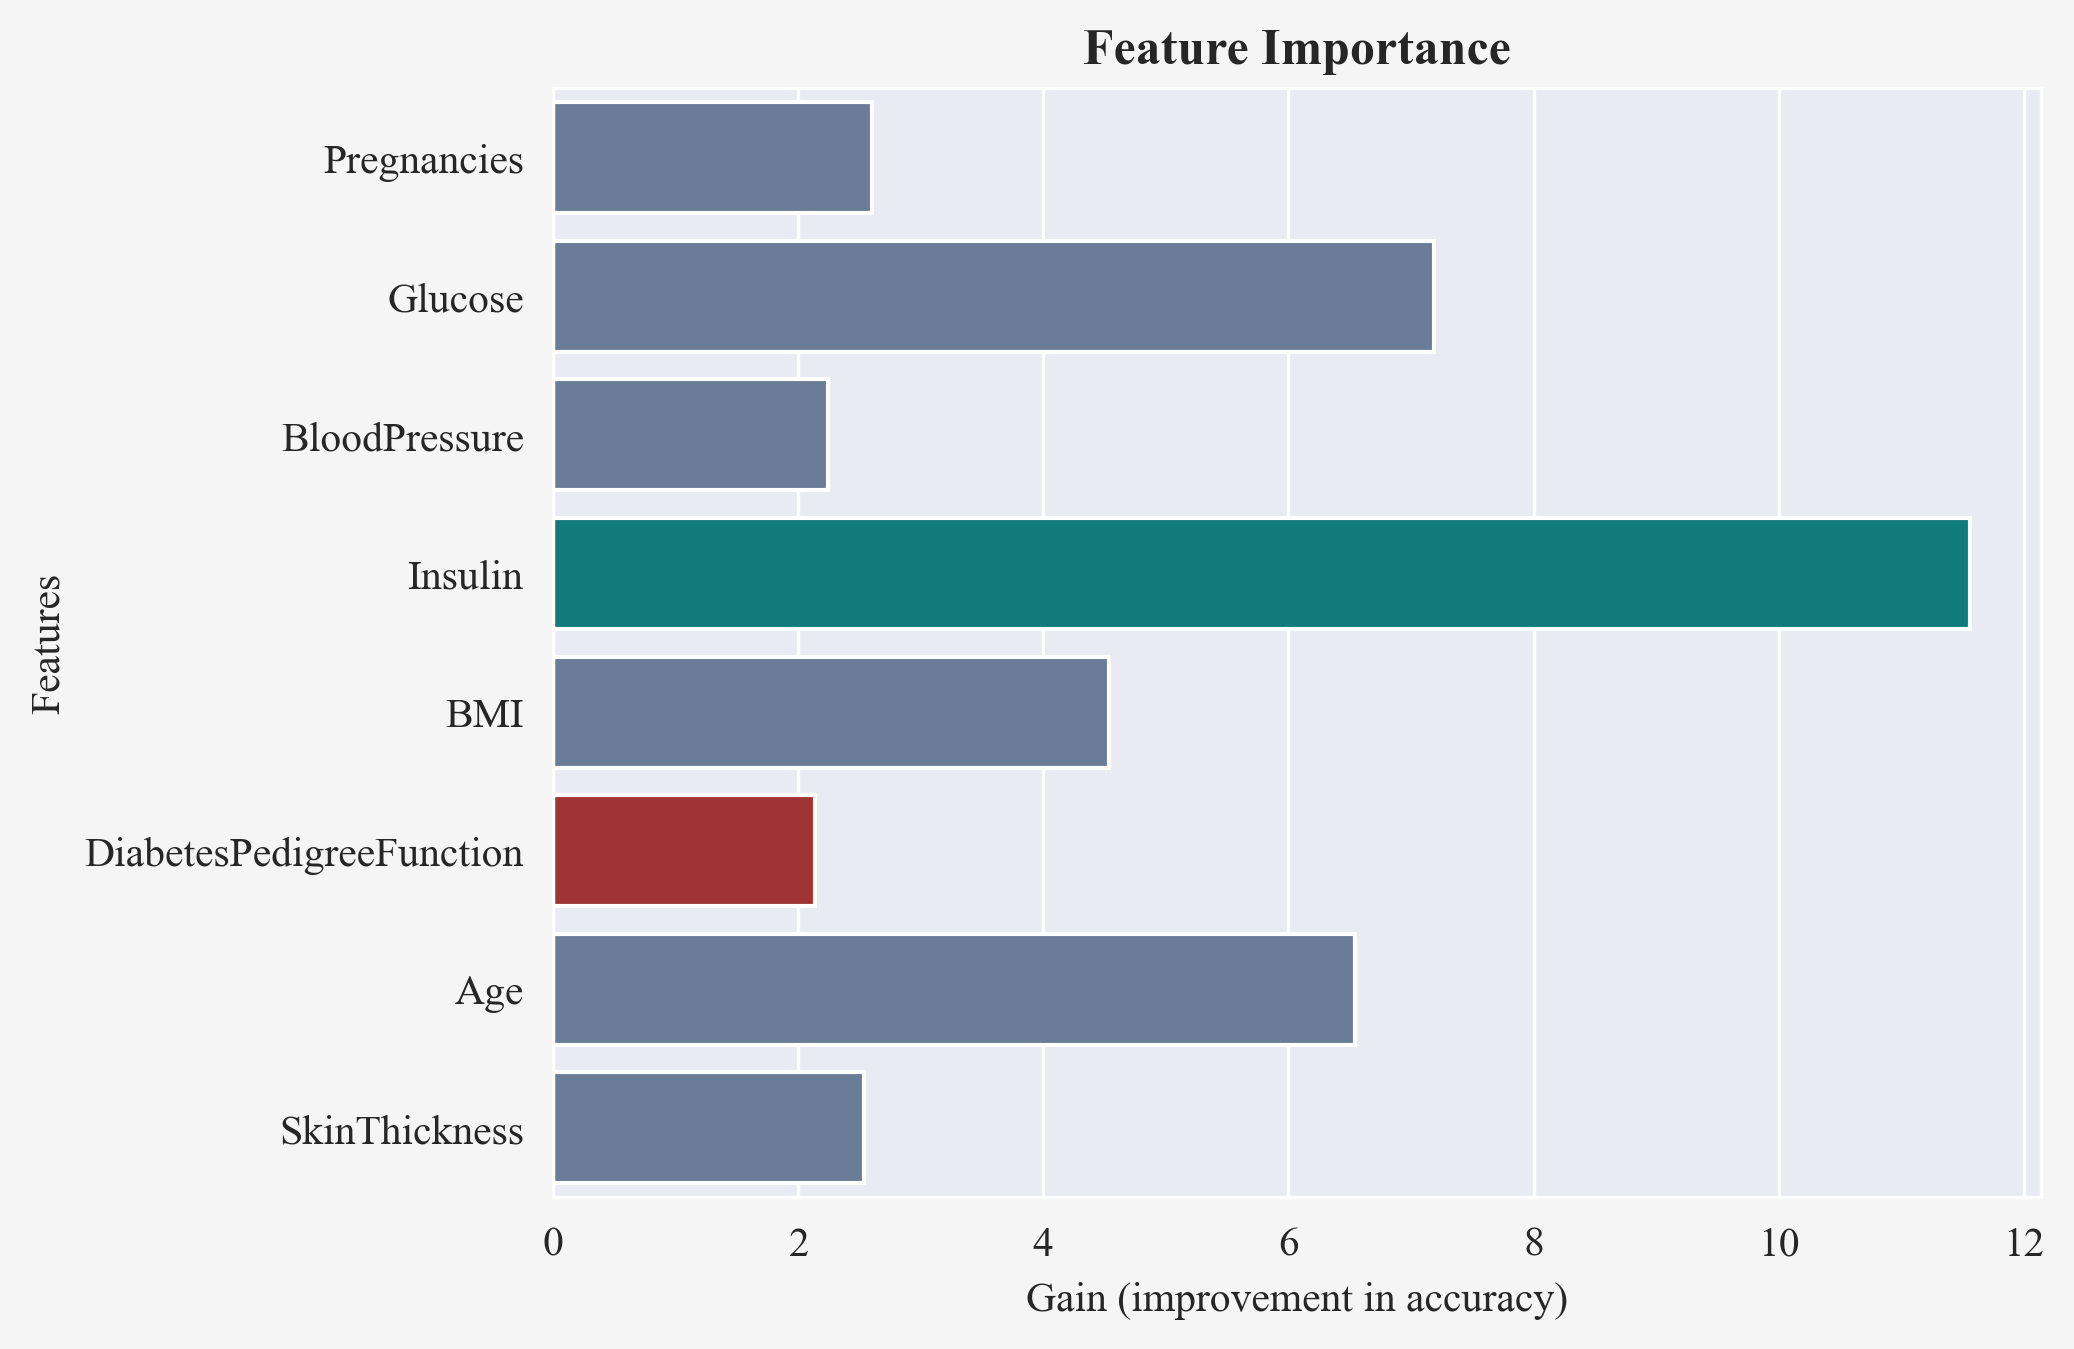

In [78]:
palette = make_palette(clf.get_booster().get_score(importance_type='gain').values())

plt.figure(facecolor='whitesmoke', dpi=300)
sns.barplot(x = clf.get_booster().get_score(importance_type='gain').values(),
            y = ['Pregnancies','Glucose','BloodPressure','Insulin','BMI',
                 'DiabetesPedigreeFunction','Age','SkinThickness'],
            palette=palette)
plt.title('Feature Importance', weight='bold')
plt.ylabel('Features')
plt.xlabel('Gain (improvement in accuracy)');

&nbsp;

# 10. Multilayer Perceptron

### Basic hyperparameter tuning with keras `RandomSearch`

In [54]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(hp.Int('units',
                                  min_value=32,
                                  max_value=512,
                                  step=15),
                           activation='sigmoid'))
    model.add(layers.Dense(hp.Int('units',
                                  min_value=32,
                                  max_value=256,
                                  step=7),
                           activation='sigmoid'))
    model.add(layers.Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='binary_crossentropy')
    return model

rs = RandomSearch(build_model,
                  objective='val_loss',
                  max_trials=5,
                  executions_per_trial=3,
                  directory='cv_reports',
                  project_name='MLP_Diabetes')

rs.search_space_summary()

Reloading Tuner from cv_reports\MLP_Diabetes\tuner0.json
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 550, 'step': 100, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [55]:
rs.search(X_est_scaled,y_est,
          epochs=200,
          validation_data=(X_val_scaled,y_val))
rs.results_summary()

Results summary
Results in cv_reports\MLP_Diabetes
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
units: 150
activation: sigmoid
learning_rate: 0.001
Score: 0.47436095476150514

Trial 3 summary
Hyperparameters:
units: 250
activation: relu
learning_rate: 0.001
Score: 0.5506467700004578

Trial 4 summary
Hyperparameters:
units: 550
activation: relu
learning_rate: 0.001
Score: 0.5678556442260743

Trial 5 summary
Hyperparameters:
units: 450
activation: sigmoid
learning_rate: 0.001
Score: 1.5751745462417603

Trial 0 summary
Hyperparameters:
units: 250
activation: relu
learning_rate: 0.01
Traceback (most recent call last):
  File "C:\Users\NiC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\NiC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\

### Finalise MLP model

In [56]:
model = tf.keras.Sequential([
    layers.Dense(450, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss= keras.losses.binary_crossentropy,
    optimizer= keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

history = model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5977 - loss: 0.6687 - precision: 0.4559 - recall: 0.1654        
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6857 - loss: 0.6123 - precision: 0.6184 - recall: 0.8861 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7244 - loss: 0.5566 - precision: 0.7586 - recall: 0.6191 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7634 - loss: 0.5235 - precision: 0.7298 - recall: 0.7804 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7561 - loss: 0.4907 - precision: 0.7619 - recall: 0.7180 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7288 - loss: 0.5003 - precision: 0.6920 - recall: 0.6900 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7942 - loss: 0.4665 - precision: 0.8086 - recall: 0.7892 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7591 - loss: 0.4988 - precision: 0.7579 - recall: 0.7266 
Epoch 9/1

### Model Metrics for different epochs

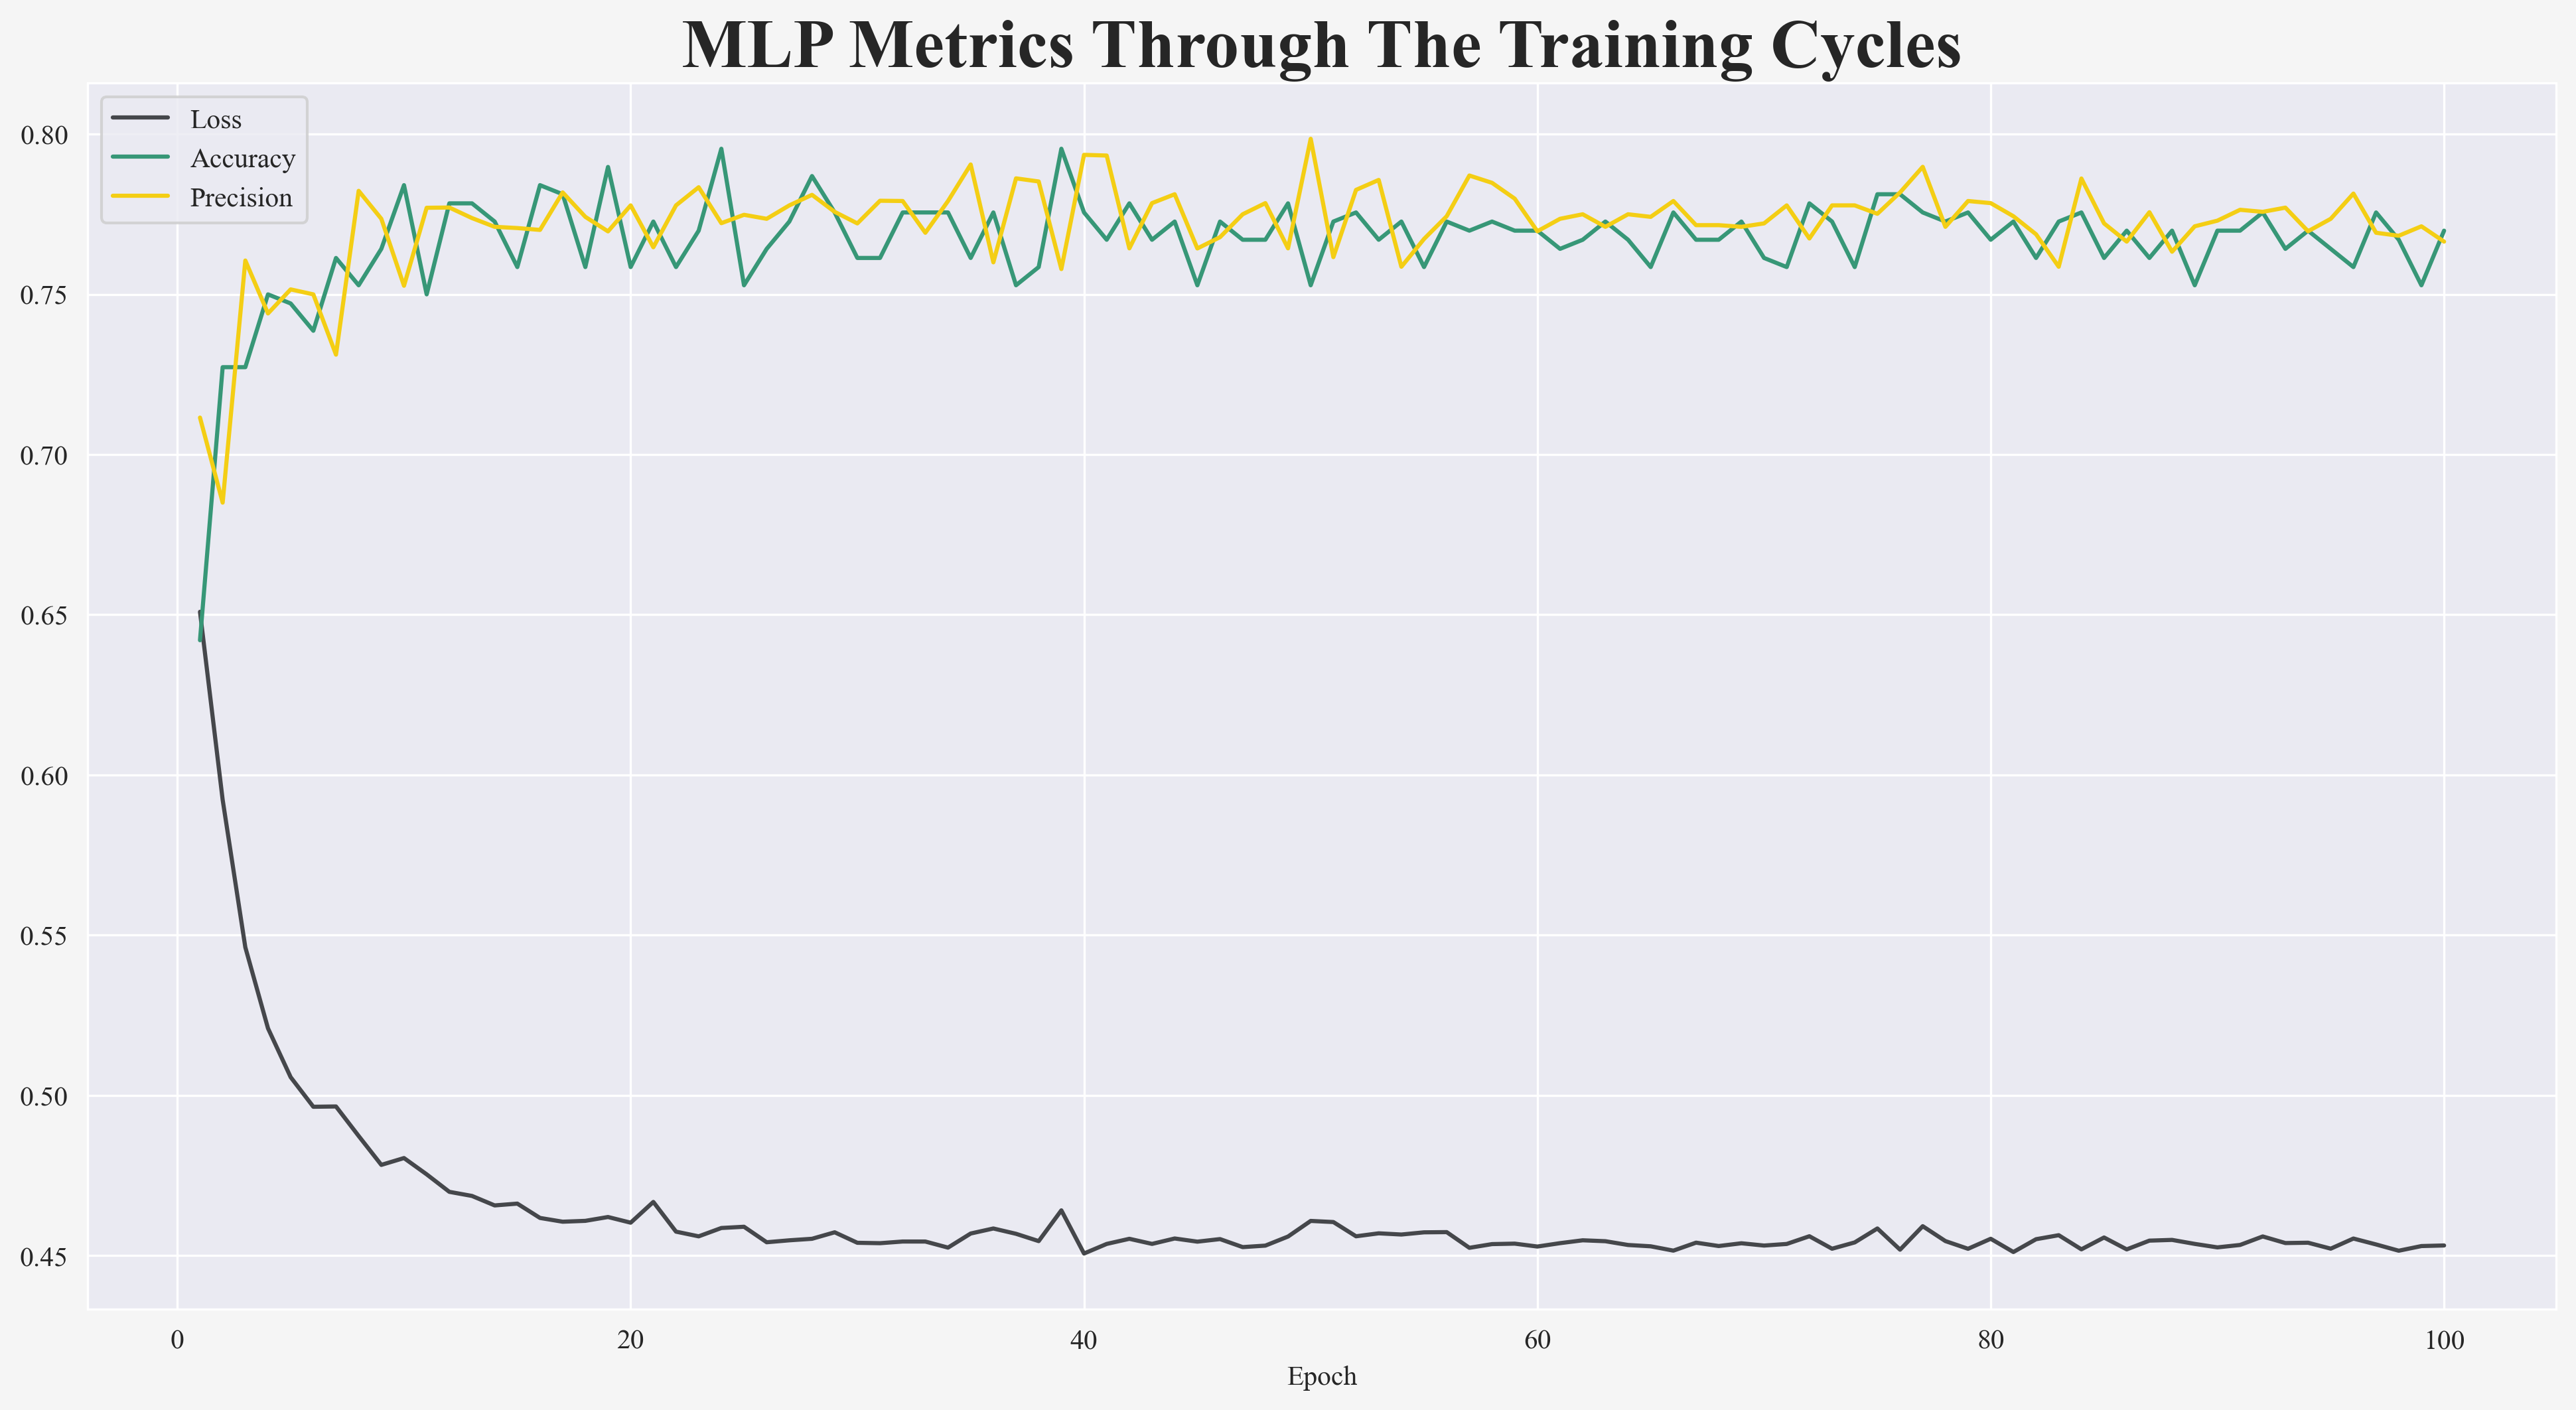

In [57]:
plt.figure(figsize=(16,8), facecolor='whitesmoke', dpi=300)
sns.lineplot(x=np.arange(1,101), y=history.history['loss'], label='Loss', color='#45474B')
sns.lineplot(x=np.arange(1,101), y=history.history['accuracy'], label='Accuracy', color='#379777')
sns.lineplot(x=np.arange(1,101), y=history.history['precision'], label='Precision', color='#F4CE14')
plt.title('MLP Metrics Through The Training Cycles', weight='bold', size=25)
plt.xlabel('Epoch');

In [61]:
y_train_probs = model.predict(X_train_scaled).reshape(((X_train_scaled.shape[0],)))
y_train_pred = (y_train_probs > .5).astype('int'); pred_train['MLP'] = y_train_pred
y_test_probs = model.predict(X_test_scaled).reshape(((X_test_scaled.shape[0],)))
pred_probs['MLP'] = y_test_probs
y_test_pred = (y_test_probs > .5).astype('int'); pred_test['MLP'] = y_test_pred

print("MLP Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("MLP Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("MLP Train Precision:", precision_score(y_train, y_train_pred))
print("MLP Test Precision:", precision_score(y_test, y_test_pred))
print("MLP Train F1 Score:", f1_score(y_train, y_train_pred))
print("MLP Test F1 Score:", f1_score(y_test, y_test_pred))
print("MLP Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("MLP Test Specificity:", calc_specificity(y_test, y_test_pred))
print("MLP Test Misclass:", calc_misclass(y_test, y_test_pred))
print("MLP Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MLP Train Accuracy: 0.7698863636363636
MLP Test Accuracy: 0.7697368421052632
MLP Train Precision: 0.7696969696969697
MLP Test Precision: 0.7901234567901234
MLP Train F1 Score: 0.7582089552238805
MLP Test F1 Score: 0.7852760736196319
MLP Test Sensitivity: 0.78049
MLP Test Specificity: 0.75714
MLP Test Misclass: 0.23026315789473684
MLP Confusion Matrix:
 [[53 17]
 [18 64]]


&nbsp;

# 11. Long Short-Term Memory

In [13]:
#Ensure data is fed in expected format
X_train_scaled = np.asarray(X_train_scaled).astype('float32')
X_test_scaled = np.asarray(X_test_scaled).astype('float32')
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
y_train = np.array(y_train).reshape((y_train.shape[0], 1, 1))
y_test = np.array(y_test).reshape((y_test.shape[0], 1, 1))

#Define model
model = keras.Sequential()
model.add(layers.LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(layers.LSTM(50, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

#Fit model
history = model.fit(X_train_scaled, y_train, epochs=200, validation_split=.2, verbose=1)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.4465 - val_loss: 0.3828
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3585 - val_loss: 0.2661
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2437 - val_loss: 0.1710
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1815 - val_loss: 0.1400
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1762 - val_loss: 0.1391
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1523 - val_loss: 0.1342
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1506 - val_loss: 0.1348
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1628 - val_loss: 0.1320
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1532 - val_loss: 0.1296
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1629 - val_loss: 0.1292
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1479 - val_loss: 0.1286
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1463 - val_loss: 0.1282


In [25]:
y_train_probs = model.predict(X_train_scaled).reshape(((X_train_scaled.shape[0],)))
y_train_pred = (y_train_probs > .5).astype('int'); pred_train['LSTM'] = y_train_pred
y_test_probs = model.predict(X_test_scaled).reshape(((X_test_scaled.shape[0],)))
pred_probs['LSTM'] = y_test_probs
y_test_pred = (y_test_probs > .5).astype('int'); pred_test['LSTM'] = y_test_pred

y_train = y_train.reshape(y_train_pred.shape)
y_test = y_test.reshape(y_test_pred.shape)

print("LSTM Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("LSTM Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("LSTM Train Precision:", precision_score(y_train, y_train_pred))
print("LSTM Test Precision:", precision_score(y_test, y_test_pred))
print("LSTM Train F1 Score:", f1_score(y_train, y_train_pred))
print("LSTM Test F1 Score:", f1_score(y_test, y_test_pred))
print("LSTM Test Sensitivity:", calc_sensitivity(y_test, y_test_pred))
print("LSTM Test Specificity:", calc_specificity(y_test, y_test_pred))
print("LSTM Test Misclass:", calc_misclass(y_test, y_test_pred))
print("LSTM Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
LSTM Train Accuracy: 0.8977272727272727
LSTM Test Accuracy: 0.756578947368421
LSTM Train Precision: 0.8941176470588236
LSTM Test Precision: 0.7777777777777778
LSTM Train F1 Score: 0.8941176470588236
LSTM Test F1 Score: 0.7730061349693251
LSTM Test Sensitivity: 0.76829
LSTM Test Specificity: 0.74286
LSTM Test Misclass: 0.24342105263157895
LSTM Confusion Matrix:
 [[52 18]
 [19 63]]


&nbsp;

# Final Results

| Model | Accuracy Train | Accuracy Test | Precision Train | Precision Test | F1 Train | F1 Test | Sensitivity Test | Specificity Test | Misclass Test |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| `LR` | 0.75 | 0.7895 | 0.7971 | 0.8472 | 0.7143 | 0.7922 | 0.7439 | 0.8429 | 0.2105 |
| `SVM(Linear)` | 0.7841 | 0.7961 | 0.7937 | 0.8312 | 0.7697 | 0.8050 | 0.7805 | 0.8143 | 0.2039 |
| `SVM(Poly)` | 0.8437 | 0.7961 | 0.9078 | 0.8592 | 0.8232 | 0.7974 | 0.7439 | 0.8571 | 0.2039 |
| `SVM(RBF)` | 0.7898 | 0.7961 | 0.7759 | 0.8072 | 0.7849 | 0.8121 | 0.8171 | 0.7714 | 0.2039 |
| `KNN` | 0.7983 | 0.7895 | 0.7929 | 0.8049 | 0.7906 | 0.8049 | 0.8049 | 0.7714 | 0.2105 |
| `NB` | 0.7898 | 0.7961 | 0.7791 | 0.8148 | 0.7836 | 0.8098 | 0.8049 | 0.7857 | 0.2039 |
| `LDA` | 0.7614 | 0.7961 | 0.7756 | 0.84 | 0.7423 | 0.8025 | 0.7683 | 0.8286 | 0.2039 |
| `QDA` | 0.8011 | 0.7829 | 0.8165 | 0.8267 | 0.7866 | 0.7898 | 0.7561 | 0.8143 | 0.2171 |
| `DT` | 0.8494 | 0.8224 | 0.8874 | 0.8873 | 0.8349 | 0.8235 | 0.7683 | __0.8857__ | 0.1776 |
| `RF` | 0.9716 | 0.8618 | 0.9819 | 0.8588 | 0.9702 | 0.8743 | __0.8902__ | 0.8286 | 0.1382 |
| `XGBOOST` | 0.9148 | __0.8816__ | 0.9167 | __0.9__ | 0.9112 | __0.8889__ | 0.8780 | __0.8857__ | __0.1184__ |
| `MLP` | 0.7699 | 0.7697 | 0.7697 | 0.7901 | 0.7582 | 0.7853 | 0.7805 | 0.7571 | 0.2303 |
| `LSTM` | 0.8977 | 0.7566 | 0.8941 | 0.7778 | 0.8941 | 0.7730 | 0.7683 | 0.7429 | 0.2434 |

&nbsp;

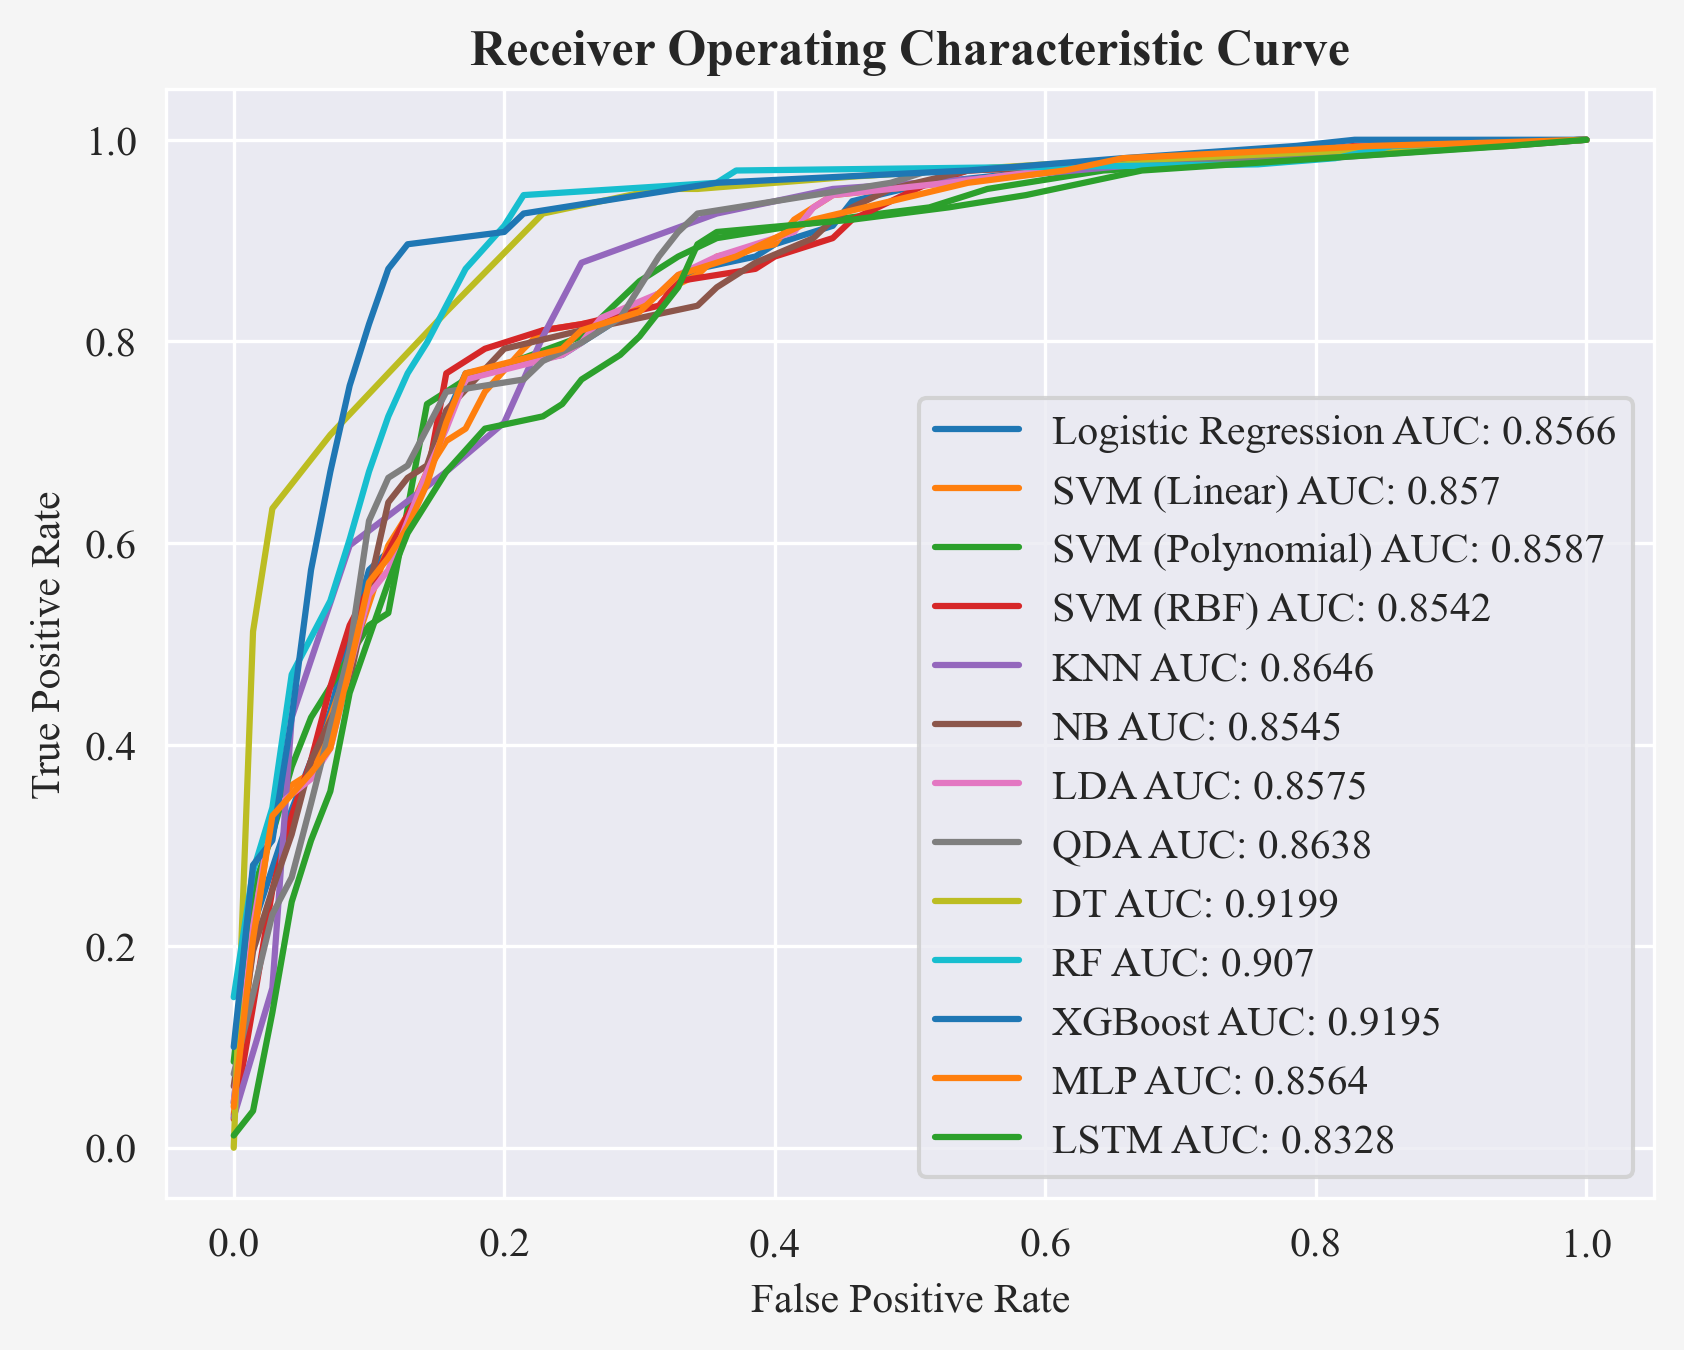

In [30]:
plt.figure(facecolor='whitesmoke', dpi=300)

pred_probs.columns = ['Logistic Regression',
                      'SVM (Linear)',
                      'SVM (Polynomial)',
                      'SVM (RBF)',
                      'KNN',
                      'NB',
                      'LDA',
                      'QDA',
                      'DT',
                      'RF',
                      'XGBoost',
                      'MLP',
                      'LSTM']

for model in pred_probs.columns:
    fpr, tpr, _ = roc_curve(y_test, pred_probs[model])
    model_auc = np.round(auc(fpr, tpr),4)
    sns.lineplot(x=fpr, y=tpr, label=f'{model} AUC: {model_auc}', ci=None)

plt.title('Receiver operating characteristic curve'.title(), weight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');